# Short-Term Rental Platform Versus Find a Long-Term Tenant: Evaluating Expected Profits

# Introduction

Short-term rental industry as of late as been a big focus for the sharing economy and local and state government. People who have been putting their dwelling (Hosts) on platforms such as AirBnB and HomeAway are able to make money by making use of empty room or perhaps their whole house or apartment on these platforms. Local and State governments are taking notice because these platforms are bypassing the local Hotel Occupancy Taxes, which hotel guests have to pay.  No doubt the Hotel Lobbyists are putting pressure like how Taxi Lobbyists put pressure on officials with Uber, Lyft and similar companies. 

Property Management companies are also using these platforms because they can generate more profit than long-term leases, depending on what areas (i.e.Santa Monica, New York City). Sharing Economy tends to create a demand bubble, causing prices to increase. Due to this reason as well as bypassing Hotel Occupancy Taxes, many local and state officials are banning listings that are entire units. Austin, Santa Monica, San Francisco all have put severe restrictions into number of days that the unit can be listed, requiring permits, and/or banned entire unit rentals. New York signed a law stating that short-term rentals that consist of entire unit is now illegal, although it is still in legal limbo. 

First analysis concentrates on if makes financial sense to get a two-bedroom, and put the extra room on a STR platform versus finding a long-term rental. This depends on the cost of the apartment and the price that room can generate on a STR platform. Location matters for both the cost of the apartment and the average price on the STR platform as both are a function of demand.


Second Analysis will concentrate on full-time rentals, concentrating on the amount the rental can generate per month minus the rent of the rental per month. Since maximum price and occupancy are affected by seasonality, they will not be constant throughout the year.

# Methodology & Data Sources

Using AirBnB data and Zillow data, I will use a machine learning algorithm to predict airbnb prices by month by neighborhood and by bedrooms to get a sense of how pricing differs. Then calculate the average yearly price and occupancy, apply it to zillow data to see the expected profit.


The data sources used in this analysis were:
#### 1) Zillow
* Links were manually entered by finding the URL for specific neighborhood in Zillow

* Scraped Zillow Listings for most of Manhattan and for most of Brooklyn

#### 2) AirBnB
* The data for AirBnB was downloaded from http://insideairbnb.com/get-the-data.html
* It is uncertain how the data was pulled, as a lot of contributors were assocated with this website

More details on the methodology will be explained later on in this analysis.

### Importing Libraries

In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

year = datetime.now().year
month = datetime.now().month
day = datetime.now().day

if day < 10:
    date = str(month)+"0"+str(day)+str(year)
else:
    date = str(month)+str(day)+str(year)

## Zillow

Zillow listings for New York City were scraped to compute the expected profits from Short-Term Rental. From the AirBnB analysis, ADR is calculated for a 'Private room' type, as well as occupancy percentage for each neighborhood, such that expected revenues are realized for each listing. From there further analysis can be done to gauge expected profits, but that will go into more detail later. The following steps were taken for scraping Zillow:

1) Write down all the URL links to each neighborhood I wanted to scrape in Zillow, which can be found in the scraping_links.csv file. Since the neighborhood naming conventions might be ambiguous, it was best if this part was down manually.

2) Go through all the listins in the main link for each neighborhood (including the total amount of pages).

3) Grab the individual links for each listing. Some were the individual listings, some where routed to the building link, which had multiple listings within the link.
    * If it was routed to a building link, scrape all the individual links
4) Once all the individual links were found (denoted by '/homedetails'), iterate through each listing and grab all the pertinent information such as address, rental price, beds, bath, sqft

5) Conduct separate scrapes for any neighborhood that failed (i.e. Financial District) or any individual listings that were skipped.

6) Combine into a single dataframe


#### There are several .py files associated with the scraping and cleaning of the data:

1) zillow_scrape.py - pulls all listings from scraping_links.csv that contains urls to each neighborhood.
    * The data contain duplicates, so they were dropped
    * All the links that had "/b/" are apartment building links that contained multiple listings.

2) all_b_listings.py - all the links that had "/b/" were scraped to find the "/homedetails" link

3) home_details_scrape.py - having all the "/homedetails" links, a third zillow scrape was performed to capture data.

### Assumptions/Risks

1) The borders in Zillow are not defined. I could scrape 'Midtown East' and the listing could be in Midtown. Using a combination of zipcode and neighborhood was the best method in associating a listing with the correct neighborhood.

2) Missing data for Square Feet. Since this is one half of the Rental Price per Square Foot, it is crucial to have this information. The missing values were imputed from running a regression on the missing square foot values by using the known square foot values as the training set.

3) Zillow updates listing urls frequently, so there is a probability that the link might not exist the next day.

4)


### Exploratory Data Analysis






In [621]:
#these three files contain all the scraped data from individual listings
home_1000 = pd.read_json('zillow_files/home_1000.json')
home_2000 = pd.read_json('zillow_files/home_2000.json')
home_3000 = pd.read_json('zillow_files/home_3000.json')
home_1000_2000 = home_1000.append(home_2000)
zillow_home = home_1000_2000.append(home_3000)
zillow_home.reset_index(inplace = True,drop=True)

#Creating a zipcode column and type conversions
zillow_home['zipcode'] = zillow_home['address'].apply(lambda x: x.split(' ')[-2])
zillow_home['price'] = zillow_home['price'].apply(lambda x: x.replace(' /mo','').replace(',','').replace('$','').replace('+','')).astype(int)
zillow_home['sqft'] = zillow_home['sqft'].apply(lambda x: x.replace(' sqft','').replace(',','').replace('--','0')).astype(int)
zillow_home['beds'] = zillow_home['beds'].apply(lambda x: x.replace(' beds','').replace(' bed','').replace('Studio','0'))
print zillow_home.shape

#all_b_listings_df = pd.read_csv('zillow_files/all_b_listings.csv')


#manually verified links to see the number of bedrooms
zillow_home['beds'] = zillow_home['beds'].apply(lambda x: 1 if x=='--' else x).astype(int)


#calculating price per sqft
price_per_foot = []
for x,y in zip(zillow_home['price'],zillow_home['sqft']):
    if y!=0:
        price_per_foot.append(round(x/float(y),2))
    else:
        price_per_foot.append(0)
zillow_home['price/sqft'] = price_per_foot

#converting baths
zillow_home['baths'] = zillow_home['baths'].apply(lambda x: x.replace(' baths','').replace(' bath',''))
#from manual inspect, these are apartments with 1 bathroom
zillow_home['baths'] = zillow_home['baths'].apply(lambda x: 1 if x=="--" else x).astype(float)

#converting zipcode
zillow_home['zipcode'] = zillow_home['zipcode'].astype(int)

#merging to get the original link
zillow_home = pd.merge(zillow_home,all_b_listings_df.loc[:,['list_url','main_url']],how="left")

#converting main_url into the full link
zillow_home['main_url'] = zillow_home['main_url'].apply(lambda x: "null" if type(x)== float else x)
main_url = []
for x,y in zip(zillow_home['list_url'],zillow_home['main_url']):
    if y == "null":
        main_url.append(x.replace('http://www.zillow.com',''))
    else:
        main_url.append(y)
zillow_home['link'] = main_url
del zillow_home['main_url']

#calling the dataframe that has zipcode, neighborhood, area
zip_neighborhood = pd.read_csv("../zipcode_neighborhood.csv",index_col = 0)
#merge the zipcode/neighborhood
zillow_home = pd.merge(zillow_home,zip_neighborhood,on='zipcode')

print 'Max Sqft is:',zillow_home['sqft'].max()
#restrict sqft and limit to 4 bedrooms max as that is the comparison
#with airbnb
zillow_home = zillow_home[(zillow_home['beds']<5) & (zillow_home['sqft']<3000)]
#saving the dataframe
zillow_home.to_csv('zillow_files/zillow_cleaned_'+date+'.csv')

zillow_home.head()

(2064, 8)
Max Sqft is: 56350


address  baths  beds  \
0  300 W 49th St APT 502, New York, NY 10019     1.0     2   
1    457 W 57th St # 207, New York, NY 10019     1.0     0   
2   171 W 57th St APT 4A, New York, NY 10019     3.0     3   
3   405 W 50th St APT 3C, New York, NY 10019     1.0     1   
4     703 9th Ave APT 3D, New York, NY 10019     1.0     1   

                                            list_url  listing_num  price  \
0  http://www.zillow.com/homedetails/300-W-49th-S...            0   2600   
1  http://www.zillow.com/homedetails/457-W-57th-S...            1   2300   
2  http://www.zillow.com/homedetails/171-W-57th-S...            2  10500   
3  http://www.zillow.com/homedetails/405-W-50th-S...            3   2354   
4  http://www.zillow.com/homedetails/703-9th-Ave-...            4   2195   

   sqft  zipcode  price/sqft  \
0     0    10019        0.00   
1     0    10019        0.00   
2  1945    10019        5.40   
3     0    10019        0.00   
4   500    10019        4.39   

                                                link    neighborhood  \
0  /homedetails/300-W-49th-St-APT-502-New-York-NY...  Hell's Kitchen   
1  /homedetails/457-W-57th-St-207-New-York-NY-100...  Hell's Kitchen   
2  /homedetails/171-W-57th-St-APT-4A-New-York-NY-...  Hell's Kitchen   
3  /homedetails/405-W-50th-St-APT-3C-New-York-NY-...  Hell's Kitchen   
4  /homedetails/703-9th-Ave-APT-3D-New-York-NY-10...  Hell's Kitchen   

        area sub_area  
0  Manhattan  Midtown  
1  Manhattan  Midtown  
2  Manhattan  Midtown  
3  Manhattan  Midtown  
4  Manhattan  Midtown

### Visualizations


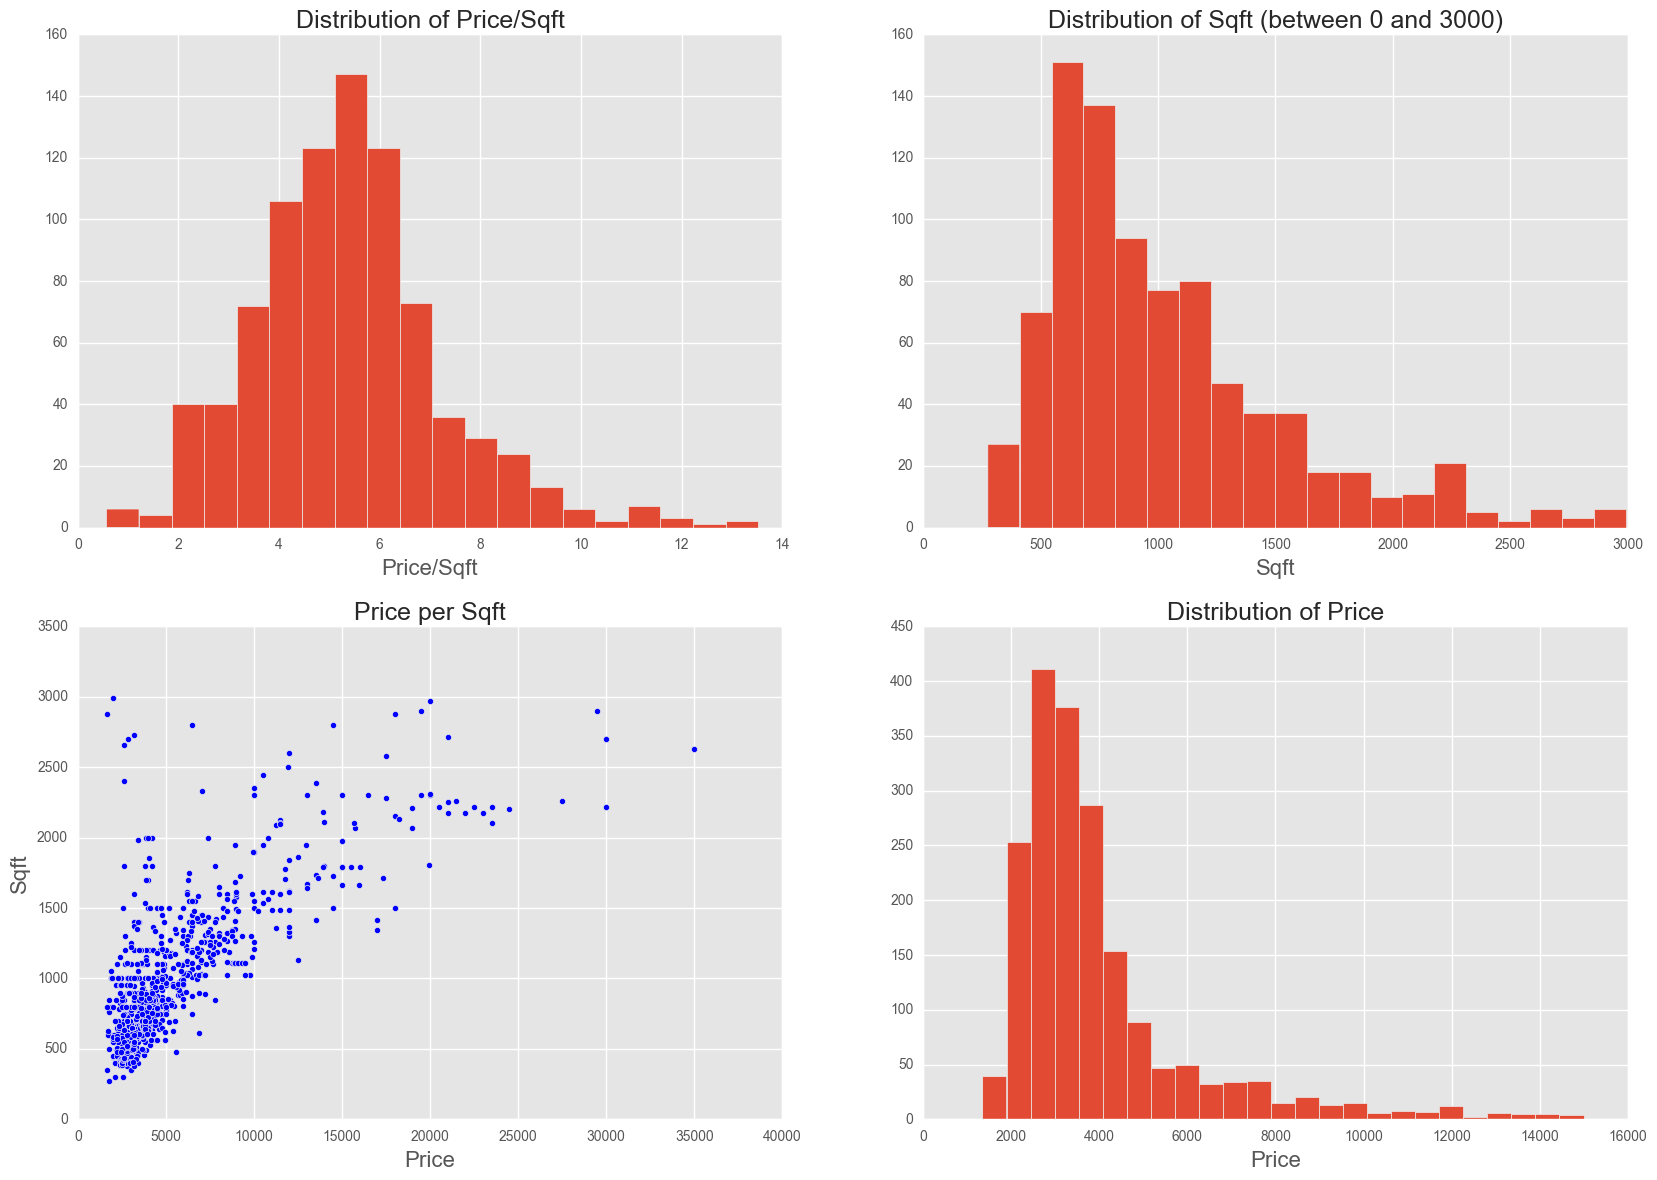

In [4]:
fig,axes = plt.subplots(2,2,figsize=(20,14))
axes[0][0].hist(x = zillow_home[zillow_home['price/sqft']>0]['price/sqft'],bins = 20) 
axes[0][0].set_title("Distribution of Price/Sqft",fontsize = 18)
axes[0][0].set_xlabel("Price/Sqft",fontsize = 16)

axes[0][1].hist(x=zillow_home[(zillow_home['sqft']>0) & (zillow_home['sqft']<3000)]['sqft'],bins=20)
axes[0][1].set_title('Distribution of Sqft (between 0 and 3000)',fontsize=18)
axes[0][1].set_xlabel('Sqft',fontsize=16)


axes[1][0].scatter(x=zillow_home[zillow_home['price/sqft']>0]['price'],y=zillow_home[zillow_home['price/sqft']>0]['sqft']);
axes[1][0].set_title('Price per Sqft',fontsize=18)
axes[1][0].set_xlabel('Price',fontsize=16)
axes[1][0].set_ylabel('Sqft',fontsize=16)
axes[1][0].set_xlim(0,40000)


axes[1][1].hist(x=zillow_home[zillow_home['price']<15000]['price'],bins=25)
axes[1][1].set_title('Distribution of Price',fontsize=18)
axes[1][1].set_xlabel('Price',fontsize=16);

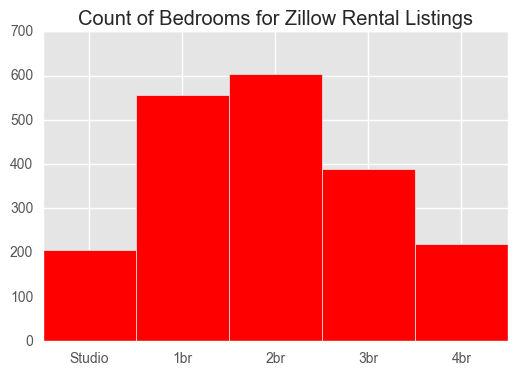

In [622]:
ind = np.arange(1,6)  # the x locations for the groups
width = 1       # the width of the bars

bed_count = zillow_home.groupby('beds')['beds'].count().to_frame('bed_count')
bed_count.reset_index(inplace = True)
bed_count['bed_count']
fig, ax = plt.subplots()
rects1 = ax.bar(ind, bed_count['bed_count'], width, color='r')
plt.xticks([x+.5 for x in ind],('Studio','1br','2br','3br','4br'));
plt.title("Count of Bedrooms for Zillow Rental Listings");

### Model - Predicting SQFT on missing values in the dataframe

After scraping zillow, there were missing values for square foot column. Since this is needed to calculate price per square foot, the values need to be imputed via regression

In [480]:

zillow_data = zillow_home.loc[:,['baths','beds','price','sqft','zipcode','neighborhood']]
zillow_data['neighborhood'] = le.fit_transform(zillow_data['neighborhood'])
zillow_data['zipcode'] = le.fit_transform(zillow_data['zipcode'])

zillow_test = zillow_data[zillow_home['sqft']==0]
zillow_df = zillow_data[zillow_home['sqft']>0]
y_z = zillow_df['sqft']
X_z = zillow_df.loc[:,['baths','beds','price','zipcode','neighborhood']]
print X_z.corr()
Xzpred = zillow_test.loc[:,['baths','beds','price','zipcode','neighborhood']]

Xz_train,Xz_test,yz_train,yz_test = train_test_split(X_z,y_z,test_size = 0.33,random_state = 25)

                 baths      beds     price   zipcode  neighborhood
baths         1.000000  0.599061  0.799629 -0.170321      0.212222
beds          0.599061  1.000000  0.411151  0.233658      0.137451
price         0.799629  0.411151  1.000000 -0.335912      0.239381
zipcode      -0.170321  0.233658 -0.335912  1.000000     -0.444629
neighborhood  0.212222  0.137451  0.239381 -0.444629      1.000000


#### Linear Regression

58734.736696
0.777601278988


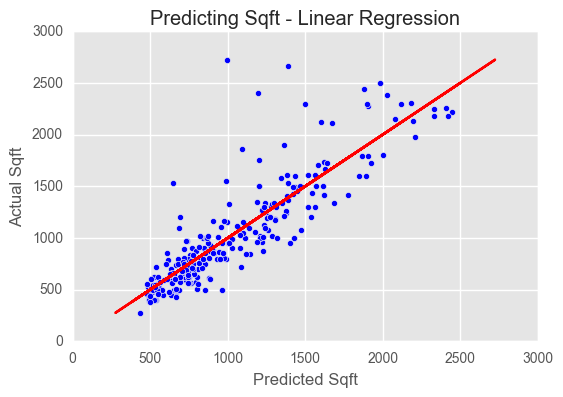

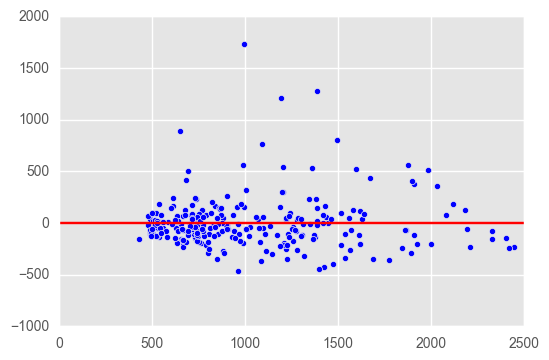

In [457]:
lrz = LinearRegression()
lrz = lrz.fit(Xz_train,yz_train)
lrz_pred = lrz.predict(Xz_test)
print mean_squared_error(yz_test,lrz_pred)
print r2_score(yz_test,lrz_pred)
plt.scatter(lrz_pred,yz_test)
plt.plot(yz_test,yz_test,color='red')
plt.title('Predicting Sqft - Linear Regression')
plt.xlabel('Predicted Sqft')
plt.ylabel('Actual Sqft')
plt.show()

plt.scatter(lrz_pred,yz_test - lrz_pred)
plt.hlines(0,0,2500,color='red')
plt.xlim(0,2500)
plt.show();

#### RidgeCV

58717.1247679
0.777667966446


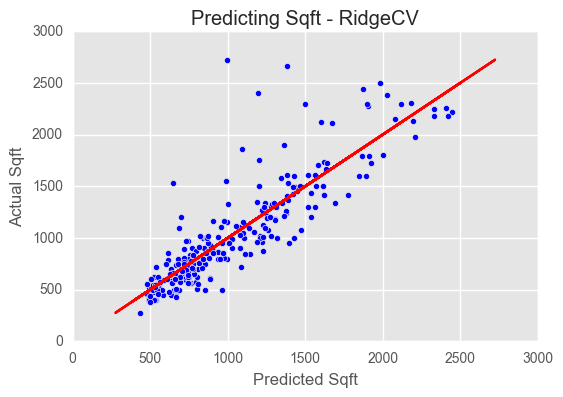

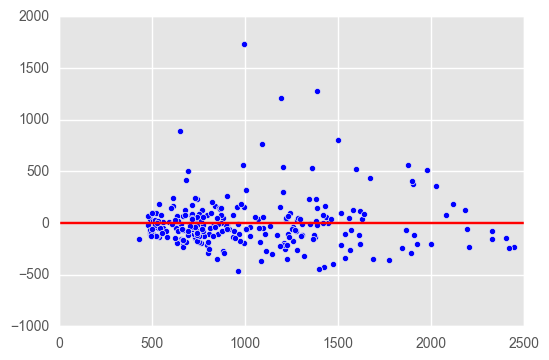

In [458]:
rcv = RidgeCV()
rcv = rcv.fit(Xz_train,yz_train)
rcv_pred = rcv.predict(Xz_test)
print mean_squared_error(yz_test,rcv_pred)
print r2_score(yz_test,rcv_pred)
plt.scatter(rcv_pred,yz_test)
plt.plot(yz_test,yz_test,color='red')
plt.title('Predicting Sqft - RidgeCV')
plt.xlabel('Predicted Sqft')
plt.ylabel('Actual Sqft')
plt.show()

plt.scatter(rcv_pred,yz_test - lrz_pred)
plt.hlines(0,0,2500,color='red')
plt.xlim(0,2500)
plt.show();

#### Extra Trees

56447.5799157
0.786261584138


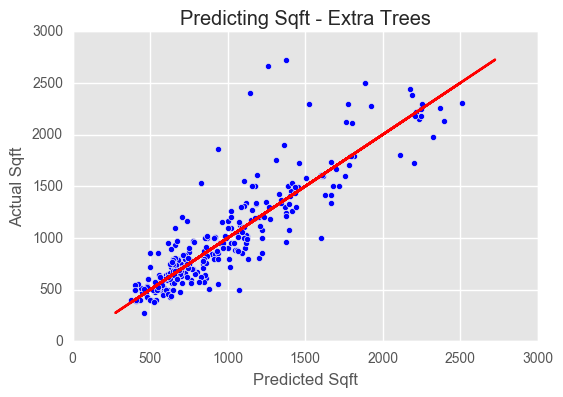

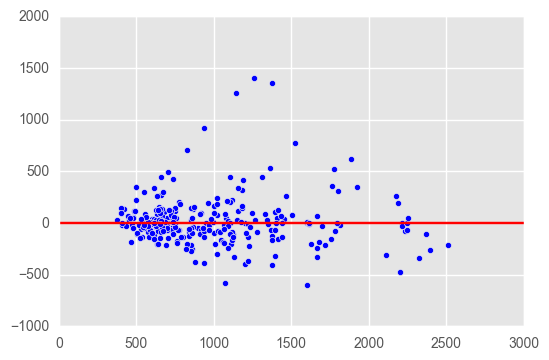

In [460]:
etz = ExtraTreesRegressor(n_estimators = 1000,n_jobs=-1)
etz = etz.fit(Xz_train,yz_train)
etz_pred = etz.predict(Xz_test)
print mean_squared_error(yz_test,etz_pred)
print r2_score(yz_test,etz_pred)
plt.scatter(etz_pred,yz_test)
plt.plot(yz_test,yz_test,color='red')
plt.title('Predicting Sqft - Extra Trees')
plt.xlabel('Predicted Sqft')
plt.ylabel('Actual Sqft')
plt.show()

plt.scatter(etz_pred,yz_test - etz_pred)
plt.hlines(0,0,3000,color='red')
plt.xlim(0,3000)
plt.show();

In [588]:
#using the zillow listings with sqft missing, predict using extra trees regression
etztest_pred = etz.predict(Xzpred)
#shape matches up with the number of missing sqft entries
print pd.Series(etztest_pred).shape
#lets add it back to the dataframe
zillow_nosqft = zillow_home[zillow_home['sqft']==0].copy()
zillow_nosqft['pred_sqft']= etztest_pred
zillow_nosqft['sqft'] = zillow_nosqft['pred_sqft']
del zillow_nosqft['pred_sqft']
#rounding and converting to integer
zillow_nosqft['sqft'] = zillow_nosqft['sqft'].round(0).astype(int)
#isolating the listings with sqft entries
zillow_sqft = zillow_home[zillow_home['sqft']>0].copy()
#appending the predicted to the ones with sqft entries
zillowdf = zillow_sqft.append(zillow_nosqft)
zillowdf.reset_index(inplace = True,drop=True)
zillowdf['price/sqft'] = (zillowdf['price']/zillowdf['sqft']).round(2)
#newly constructed dataframe
zillowdf.head()

(1117,)


address  baths  beds  \
0   171 W 57th St APT 4A, New York, NY 10019     3.0     3   
1     703 9th Ave APT 3D, New York, NY 10019     1.0     1   
2    100 W 57th St # 19I, New York, NY 10019     1.0     1   
3      129 W 56th St # 5, New York, NY 10019     1.0     3   
4  230 W 56th St APT 52A, New York, NY 10019     3.0     3   

                                            list_url  listing_num  price  \
0  http://www.zillow.com/homedetails/171-W-57th-S...            2  10500   
1  http://www.zillow.com/homedetails/703-9th-Ave-...            4   2195   
2  http://www.zillow.com/homedetails/100-W-57th-S...           72   3795   
3  http://www.zillow.com/homedetails/129-W-56th-S...           74   3300   
4  http://www.zillow.com/homedetails/230-W-56th-S...           75  11999   

   sqft  zipcode  price/sqft  \
0  1945    10019        5.40   
1   500    10019        4.39   
2   550    10019        6.90   
3   850    10019        3.88   
4  1623    10019        7.39   

                                                link    neighborhood  \
0  /homedetails/171-W-57th-St-APT-4A-New-York-NY-...  Hell's Kitchen   
1  /homedetails/703-9th-Ave-APT-3D-New-York-NY-10...  Hell's Kitchen   
2  /homedetails/100-W-57th-St-19I-New-York-NY-100...  Hell's Kitchen   
3  /homedetails/129-W-56th-St-5-New-York-NY-10019...  Hell's Kitchen   
4  /homedetails/230-W-56th-St-APT-52A-New-York-NY...  Hell's Kitchen   

        area sub_area  
0  Manhattan  Midtown  
1  Manhattan  Midtown  
2  Manhattan  Midtown  
3  Manhattan  Midtown  
4  Manhattan  Midtown

## AirBnB

AirBnB data was scraped by contributors at http://insideairbnb.com/get-the-data.html. The calendar data and listing data for 2015 and 2016 are used. Considering 2016 isnt completed yet, there will not be accurate information for November and December.

### Risks &  Assumptions

1) The listed price in the calendar scrape when the listing was available is the posted price for that day.

2) Low Occupancy and High Occupancy (monthly) are listings that are generally inactive.

    A) Low Occupancy: indicates a very high price,if anyone was willing to pay that, the host would accept.
    B) High Occupancy: indicates that the calendar was blocked off and not rented out to users. 
    C) Occupancies should generally range in 60-75% per year.
    
3) If a median price was found in the calendar scrapes, then it would be the price for that month. If one could not be found, sorrunding months or yearly median price would be used. 

4) 

Thus, limits will be put on the data in the form of a min,max occupancy % as well as a min, max price limit.

### Exploratory Data Analysis
#### Creating Functions

In [117]:
def listing_cleanup(path):
    """
    This function takes an airbnb listing and returns the columns that will be needed for merging later
    """
    listings = pd.read_csv(path)
    listings.rename(columns = {'neighbourhood_group_cleansed':'area'},inplace = True)
    
    cols_to_use = []
    for x in pd.read_json('/Users/amishdalal/DSI-NYC-2/projects/projects-capstone/AirBnB/abnb_cols_to_use.json')[0]:
        cols_to_use.append(x)
    cols_to_use.append('neighbourhood_cleansed')
    listings = listings.loc[:,cols_to_use]
    
    listings.rename(columns = {'neighbourhood':'neighborhood'},inplace = True)
    if listings['price'].dtype != 'int64':
        #converting price to int
        listings['price'] = listings['price'].apply(lambda x: x.replace('$','').replace(',','').replace('.00','')).astype(int)
    else:
        pass
    #only selecting non null bedrooms
    listings = listings[listings['bedrooms'].notnull()]
    #converting bedrooms to int
    listings['bedrooms'] = listings['bedrooms'].astype(int)
    #only selecting real beds
    listings = listings[listings['bed_type']=='Real Bed']
    
    #creating a groupby to get each listings avg price
    listings = listings.groupby(['id','neighborhood','zipcode','bedrooms','bathrooms','room_type',\
                          'number_of_reviews','review_scores_rating'])['price'].mean().to_frame()
    listings.reset_index(inplace = True)
    #ensuring that all neighborhoods are 
    nhood_area = pd.read_csv('/Users/amishdalal/DSI-NYC-2/projects/projects-capstone/AirBnB/neighbourhoods.csv')
    
    listings = pd.merge(listings,nhood_area,on=['neighborhood'])
    listings.rename(columns = {'id':'listing_id'},inplace = True)
    
    return listings


def calendars(path,listings_df,occ_lower,occ_upper,review_limit):
    """
    This function takes the calendars that were aggregated from each csv file and merges with listings dataframe.
    Also filters out low/high occupancies, takes a minimum review number, filters out 5 or more bedrooms and shared rooms
    """
    cal_df = pd.read_csv(path,index_col=0)
    cal_df.rename(columns = {'neighbourhood':'neighborhood'},inplace = True)
    
    #merging with listings df
    cal_df = pd.merge(cal_df,listings_df)

    print 'Original DataFrame shape is:',cal_df.shape
    #dropping duplicates
    cal_df.drop_duplicates(inplace = True)
    print 'DataFrame after dropping duplicates is:',cal_df.shape
    
    #dropping any room types that are null, shared room or any bedrooms greater than 5 (only using 4 or less)
    
    cal_df1 = cal_df[(cal_df['room_type'].notnull()) & (cal_df['room_type']!='Shared room') & cal_df['bedrooms'] < 5]
    
    #because there are some that are inactive listings, that could be whole calendar is blocked (high yearly occupancy)
    #or low occupancy (very high price)
    
    #setting occupancy limits
    cal_df1 = cal_df[(cal_df['occ_yr%']<=occ_upper) & (cal_df['occ_yr%']>=occ_lower)]
    
    #setting min number of reviews to indicate activity
    print 'Min number of reviews in this dataframe is:',cal_df1['number_of_reviews'].min()
    cal_df2 = cal_df1[cal_df1['number_of_reviews']>=review_limit]
    
    return cal_df2
    

    
def one_br_split(df):
    """
    This function takes the calendar dataframe that is cleaned and returns only one bedroom listings
    """
    df = df[(df['bedrooms']==1)].copy()
    df['revpar'] = (df['avg_price'] * df['occ%']/100)
    
    return df

def entire_unit_split(df):
    occ_entire = df[(df['room_type']!='Private room')].copy()
    occ_entire['bedrooms'].value_counts()
    
    competitors = occ_entire.groupby(['zipcode','neighborhood','bedrooms'])['listing_id'].count().to_frame('num_comp')
    competitors.reset_index(inplace = True)

    occ_entire = pd.merge(occ_entire,competitors,on=['zipcode','neighborhood','bedrooms'])
    occ_entire = occ_entire[occ_entire['avg_price']!=0]  
    
    return occ_entire

def histogram_1br(df1,df2,yr1,yr2,color=None):
    yr1 = str(yr1)
    yr2 = str(yr2)
    fig,axes = plt.subplots(2,2,figsize=(20,14))
    axes[0][0].hist(x = df1[(df1['room_type']=='Private room')]['avg_price'],bins=20,color=color)
    axes[0][0].set_title("Distribution of Price for Private Room for "+yr1,fontsize = 18)
    axes[0][0].set_xlabel("Price",fontsize = 16)

    axes[0][1].hist(x=df1[(df1['room_type']!='Private room')]['avg_price'],bins=20,color=color)
    axes[0][1].set_title('Distribution of Price for Entire 1BR for '+yr1,fontsize=18)
    axes[0][1].set_xlabel('Price',fontsize=16)

    axes[1][0].hist(x=df2[(df2['room_type']=='Private room')]['avg_price'],color=color)
    axes[1][0].set_title('Distribution of Price for Private Room for '+yr2,fontsize=18)
    axes[1][0].set_xlabel('Price',fontsize=16)

    axes[1][1].hist(x=df2[(df2['room_type']!='Private room')]['avg_price'],color=color)
    axes[1][1].set_title('Distribution of Price for Entire 1BR  for '+yr2,fontsize=18)
    axes[1][1].set_xlabel('Price',fontsize=16)
    plt.show();
    
    return

def histograms(df,yr,color=None):
    '''creates a histogram subplot of distribution of prices for studio/1br, 2br, 3br and 4br listings'''    
    yr = str(yr)
    fig,axes = plt.subplots(2,2,figsize=(20,14))
    axes[0][0].hist(x = df[(df['bedrooms']==1) | (df['bedrooms']==0) ]['avg_price'],bins=20,color=color)
    axes[0][0].set_title("Distribution of Price for Studio/1BR for "+yr,fontsize = 18)
    axes[0][0].set_xlabel("Price",fontsize = 16)

    axes[0][1].hist(x=df[(df['bedrooms']==2)]['avg_price'],bins=20,color=color)
    axes[0][1].set_title('Distribution of Price for 2BR for '+yr,fontsize=18)
    axes[0][1].set_xlabel('Price',fontsize=16)

    axes[1][0].hist(x=df[(df['bedrooms']==3)]['avg_price'],color=color)
    axes[1][0].set_title('Distribution of Price for 3BR for '+yr,fontsize=18)
    axes[1][0].set_xlabel('Price',fontsize=16)

    axes[1][1].hist(x=df[(df['bedrooms']==4)]['avg_price'],color=color)
    axes[1][1].set_title('Distribution of Price for 4BR for '+yr,fontsize=18)
    axes[1][1].set_xlabel('Price',fontsize=16)
    plt.show();
    return

def price_thresholds_1br(df,priv_lower,priv_upper,entire_lower,entire_upper):
    '''Setting price tresholds to remove outliers'''
    df_priv = df[(df['room_type']=='Private room')&(df['avg_price']>priv_lower) & (df['avg_price']<priv_upper)]
    df_entire = df[(df['room_type']!='Private room')&(df['avg_price']>entire_lower) & (df['avg_price']<entire_upper)]
    df_total = df_priv.append(df_entire)
    df_total.reset_index(inplace = True,drop=True)
    df_total['revpar'] = (df_total['avg_price'] * df_total['occ%']/100).round(2)
    print 'Removing outliers, the dataframe shape is:',df_total.shape
    
    return df_total

    
def price_thresholds(df,onebr_lower,onebr_upper,twobr_lower,twobr_upper,threebr_lower,threebr_upper,fourbr_lower,fourbr_upper):
    '''Setting price tresholds to remove outliers'''
    df_studio = df[(df['bedrooms']==0) & (df['avg_price']>onebr_lower) & (df['avg_price']<onebr_upper) ]
    df_1br = df[(df['bedrooms']==1) & (df['avg_price']>onebr_lower) & (df['avg_price']<onebr_upper) ] 
    df_2br = df[(df['bedrooms']==2) & (df['avg_price']>twobr_lower) & (df['avg_price']<twobr_upper) ]
    df_3br = df[(df['bedrooms']==3) & (df['avg_price']>threebr_lower) & (df['avg_price']<threebr_upper) ]
    df_4br = df[(df['bedrooms']==4) & (df['avg_price']>fourbr_lower) & (df['avg_price']<fourbr_upper) ] 
    
    df_1br = df_1br.append(df_studio)
    df_1br_2br = df_1br.append(df_2br)
    df_3br_4br = df_3br.append(df_4br)
    data = df_1br_2br.append(df_3br_4br)
    data.reset_index(inplace = True,drop=True)
    data['revpar'] = (data['avg_price'] * data['occ%']/100).round(2)
    print 'Removing outliers, the dataframe shape is:',data.shape
    return data


def trend_graphs(df,yr):
    '''Creating groupby on neighborhood and finding average occupancy and price'''
    yr = str(yr)
    occ_by_nhood = df.groupby(['neighborhood','area','bedrooms','month'])['days_per_month','occupied','listing_id'].\
                            agg({'listing_id':len,'days_per_month':sum,'occupied':sum})
    occ_by_nhood.reset_index(inplace= True)
    occ_by_nhood['occ%'] = (100*(occ_by_nhood['occupied'] / occ_by_nhood['days_per_month'])).round(2)
    occ_by_nhood_price = data_2015.groupby(['neighborhood','area','bedrooms','month'])['avg_price'].\
            agg({'avg_price_mean':np.mean,'avg_price_median':np.median})
    occ_by_nhood_price.reset_index(inplace = True)
    #merging the occupancy by neighborhood and price
    nhood_metrics = pd.merge(occ_by_nhood,occ_by_nhood_price)
    nhood_metrics['avg_price_mean'] = nhood_metrics['avg_price_mean'].astype(int)
    nhood_metrics['avg_price_median'] = nhood_metrics['avg_price_median'].astype(int)
    nhood_metrics['revpar'] = (nhood_metrics['avg_price_median'] * nhood_metrics['occ%']/100).round(2)
    
    #plotting occupancy by month by bedroom
    plt.subplots(figsize=(15,7))
    sns.distplot(nhood_metrics[nhood_metrics['bedrooms']==4]['occ%'])
    sns.pointplot(data=nhood_metrics,x='month',y='occ%',hue='bedrooms')
    plt.title('Occupancy per Month by Bedroom for '+yr,fontsize=18)
    plt.ylabel('Occupancy',fontsize=14)
    plt.xlabel('Month',fontsize = 14)
    plt.ylim(0,100)
    plt.show();
    
    #plotting price by month by bedroom
    plt.subplots(figsize=(15,7))
    sns.pointplot(data=nhood_metrics,x='month',y='avg_price_mean',hue='bedrooms')
    plt.title('Median Price per Month by Bedroom for '+yr,fontsize=18)
    plt.ylabel('Median Price',fontsize=14)
    plt.xlabel('Month',fontsize = 14)
    plt.show();
    
    #plotting RevPAR (occupancy * ADR) by month by bedroom
    plt.subplots(figsize=(15,7))
    sns.pointplot(data=nhood_metrics,x='month',y='revpar',hue='bedrooms',estimator=np.mean)
    plt.title('Median RevPAR per Month by Bedroom for '+yr,fontsize=18)
    plt.ylabel('Median RevPAR',fontsize=14)
    plt.xlabel('Month',fontsize = 14)
    plt.ylim(0,600)
    plt.show;
    return nhood_metrics

#### 2015 Listings

In [20]:
listings_15df = listing_cleanup('airbnb_files/listings_122015.csv')
listings_15df.head()

listing_id    neighborhood zipcode  bedrooms  bathrooms        room_type  \
0         105  Hell's Kitchen   10036         1        1.0     Private room   
1        4989  Hell's Kitchen   10036         1        1.0  Entire home/apt   
2        5178  Hell's Kitchen   10019         1        1.0     Private room   
3        5818  Hell's Kitchen   10019         1        1.0     Private room   
4        5862  Hell's Kitchen   10019         2        2.0  Entire home/apt   

   number_of_reviews  review_scores_rating  price       area sub_area  
0                 39                  96.0    149  Manhattan  Midtown  
1                 13                  85.0    200  Manhattan  Midtown  
2                207                  87.0     73  Manhattan  Midtown  
3                 43                  94.0    195  Manhattan  Midtown  
4                 30                  93.0    475  Manhattan  Midtown

#### 2016 Listings

In [21]:
listings_16df = listing_cleanup('airbnb_files/listings_102016.csv')
listings_16df.head()

listing_id neighborhood zipcode  bedrooms  bathrooms        room_type  \
0        2515       Harlem   10026         1        1.0     Private room   
1        8225       Harlem   10026         1        1.0     Private room   
2        9704       Harlem   10027         1        1.5     Private room   
3       15345       Harlem   10026         1        1.0     Private room   
4       23481       Harlem   10027         1        1.0  Entire home/apt   

   number_of_reviews  review_scores_rating  price       area         sub_area  
0                143                  92.0     59  Manhattan  Upper Manhattan  
1                105                  90.0     49  Manhattan  Upper Manhattan  
2                 37                  98.0     55  Manhattan  Upper Manhattan  
3                 98                  93.0     85  Manhattan  Upper Manhattan  
4                 69                  90.0    140  Manhattan  Upper Manhattan

#### 2015 Calendar

In [153]:
path15 = 'airbnb_files/calendar_2015_agg_df_120616.csv'
occ15 = calendars(path15,listings_15df,25,80,5)

#Finding number of competitors for each neighborhood, bedroom type
num_comp15 = occ15.groupby(['neighborhood','bedrooms','room_type','listing_id'])['year'].count().to_frame('count')
num_comp15.reset_index(inplace=True)
num_comp15 = num_comp15.groupby(['neighborhood','bedrooms','room_type'])['listing_id'].count().to_frame('num_comps')
num_comp15.reset_index(inplace=True)
print occ15.shape
occ15 = pd.merge(occ15,num_comp15,on=['neighborhood','bedrooms','room_type'])
print occ15.shape
occ15.head()

occ15_1br_all = one_br_split(occ15)  
occ15_entire = entire_unit_split(occ15)


Original DataFrame shape is: (156636, 20)
DataFrame after dropping duplicates is: (156636, 20)
Min number of reviews in this dataframe is: 1
(55296, 20)
(55296, 21)


In [61]:
print 'Dataframe for calendar for all listings',occ15.shape
print 'Dataframe for 1BR units:',occ15_1br_all.shape
print 'Dataframe for Entire home/apt units:',occ15_entire.shape
occ15.head()

Dataframe for calendar for all listings (55296, 20)
Dataframe for 1BR units: (40380, 21)
Dataframe for Entire home/apt units: (34364, 21)


listing_id  year  month  days_per_month  available  occupied  occ_yr  \
0        2515  2015      1              31          5        26     254   
1        2515  2015      2              28         19         9     254   
2        2515  2015      3              31         12        19     254   
3        2515  2015      4              30         14        16     254   
4        2515  2015      5              31          7        24     254   

    occ%  occ_yr%  avg_price neighborhood zipcode  bedrooms  bathrooms  \
0  83.87    69.59       99.0       Harlem   10026         1        2.0   
1  32.14    69.59       79.0       Harlem   10026         1        2.0   
2  61.29    69.59       99.0       Harlem   10026         1        2.0   
3  53.33    69.59       99.0       Harlem   10026         1        2.0   
4  77.42    69.59       99.0       Harlem   10026         1        2.0   

      room_type  number_of_reviews  review_scores_rating  price       area  \
0  Private room                106                  94.0     59  Manhattan   
1  Private room                106                  94.0     59  Manhattan   
2  Private room                106                  94.0     59  Manhattan   
3  Private room                106                  94.0     59  Manhattan   
4  Private room                106                  94.0     59  Manhattan   

          sub_area  
0  Upper Manhattan  
1  Upper Manhattan  
2  Upper Manhattan  
3  Upper Manhattan  
4  Upper Manhattan

(55296, 21)


listing_id  year  month  days_per_month  available  occupied  occ_yr  \
0        2515  2015      1              31          5        26     254   
1        2515  2015      2              28         19         9     254   
2        2515  2015      3              31         12        19     254   
3        2515  2015      4              30         14        16     254   
4        2515  2015      5              31          7        24     254   

    occ%  occ_yr%  avg_price    ...    zipcode bedrooms  bathrooms  \
0  83.87    69.59       99.0    ...      10026        1        2.0   
1  32.14    69.59       79.0    ...      10026        1        2.0   
2  61.29    69.59       99.0    ...      10026        1        2.0   
3  53.33    69.59       99.0    ...      10026        1        2.0   
4  77.42    69.59       99.0    ...      10026        1        2.0   

      room_type number_of_reviews  review_scores_rating  price       area  \
0  Private room               106                  94.0     59  Manhattan   
1  Private room               106                  94.0     59  Manhattan   
2  Private room               106                  94.0     59  Manhattan   
3  Private room               106                  94.0     59  Manhattan   
4  Private room               106                  94.0     59  Manhattan   

          sub_area num_comps  
0  Upper Manhattan        98  
1  Upper Manhattan        98  
2  Upper Manhattan        98  
3  Upper Manhattan        98  
4  Upper Manhattan        98  

[5 rows x 21 columns]

#### 2016 Calendar

In [154]:
path16 = 'airbnb_files/calendar_2016_agg_df_120716.csv'
occ16 = calendars(path16,listings_16df,25,80,5)

#Finding number of competitors for each neighborhood, bedroom type
num_comp16 = occ16.groupby(['neighborhood','bedrooms','room_type','listing_id'])['year'].count().to_frame('count')
num_comp16.reset_index(inplace=True)
num_comp16 = num_comp16.groupby(['neighborhood','bedrooms','room_type'])['listing_id'].count().to_frame('num_comps')
num_comp16.reset_index(inplace=True)
print occ16.shape
occ16 = pd.merge(occ16,num_comp16,on=['neighborhood','bedrooms','room_type'])
print occ16.shape

occ16_1br_all = one_br_split(occ16)  
occ16_entire = entire_unit_split(occ16)

Original DataFrame shape is: (154380, 20)
DataFrame after dropping duplicates is: (154380, 20)
Min number of reviews in this dataframe is: 1
(65952, 20)
(65952, 21)


In [155]:
print 'Dataframe for calendar for all listings',occ16.shape
print 'Dataframe for 1BR units:',occ16_1br_all.shape
print 'Dataframe for Entire home/apt units:',occ16_entire.shape
occ16.head()

Dataframe for calendar for all listings (65952, 21)
Dataframe for 1BR units: (46848, 22)
Dataframe for Entire home/apt units: (37587, 22)


listing_id  year  month  days_per_month  available  occupied  occ_yr  \
0        2515  2016      1              31          8        23     203   
1        2515  2016      2              29         27         2     203   
2        2515  2016      3              31         10        21     203   
3        2515  2016      4              30          6        24     203   
4        2515  2016      5              31          6        25     203   

    occ%  occ_yr%  avg_price    ...    zipcode bedrooms  bathrooms  \
0  74.19    55.62         99    ...      10026        1        1.0   
1   6.90    55.62         59    ...      10026        1        1.0   
2  67.74    55.62         99    ...      10026        1        1.0   
3  80.00    55.62         99    ...      10026        1        1.0   
4  80.65    55.62         99    ...      10026        1        1.0   

      room_type number_of_reviews  review_scores_rating  price       area  \
0  Private room               143                  92.0     59  Manhattan   
1  Private room               143                  92.0     59  Manhattan   
2  Private room               143                  92.0     59  Manhattan   
3  Private room               143                  92.0     59  Manhattan   
4  Private room               143                  92.0     59  Manhattan   

          sub_area num_comps  
0  Upper Manhattan       137  
1  Upper Manhattan       137  
2  Upper Manhattan       137  
3  Upper Manhattan       137  
4  Upper Manhattan       137  

[5 rows x 21 columns]

### Visualizations

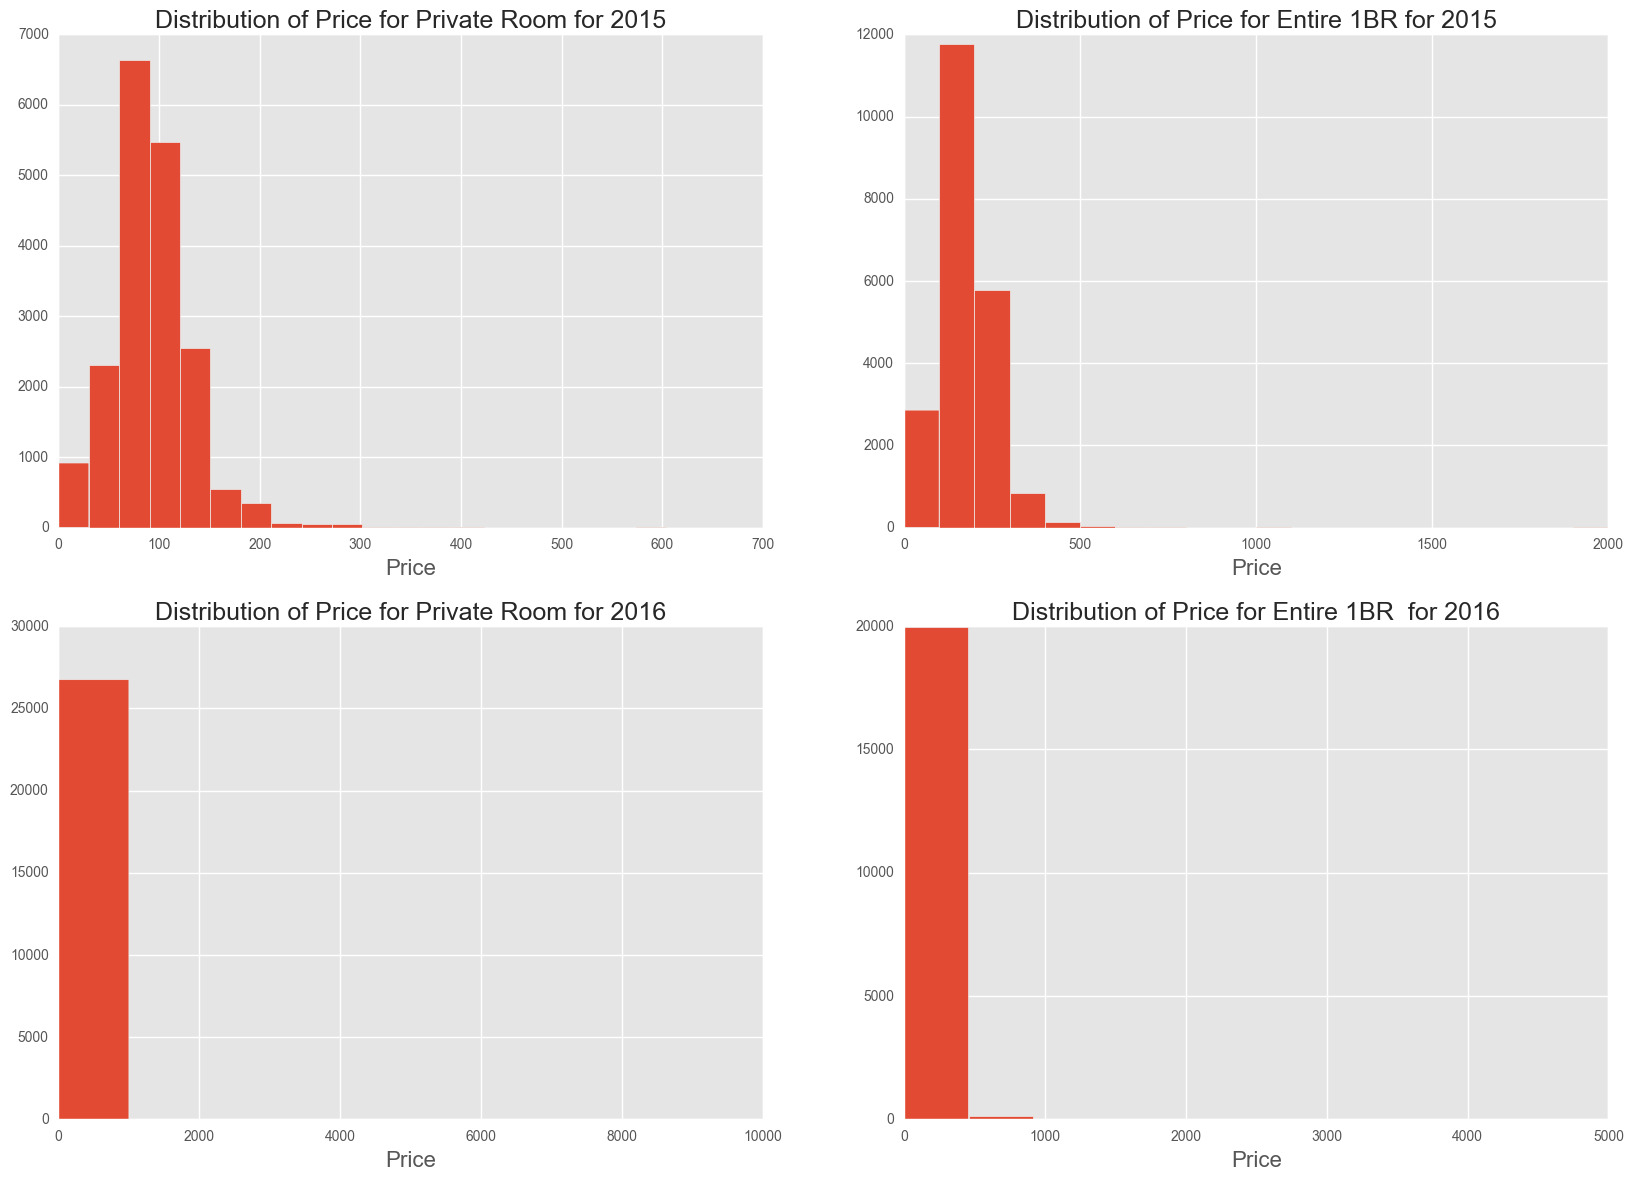

In [156]:
histogram_1br(occ15_1br_all,occ16_1br_all,2015,2016)

Histograms show highly skewed distributions, thus the need to restrict pricing to a certain threshold

In [223]:
data_1br15 = price_thresholds_1br(occ15_1br_all,40,150,50,350)
data_1br16 = price_thresholds_1br(occ16_1br_all,40,150,50,350)

Removing outliers, the dataframe shape is: (35940, 22)
Removing outliers, the dataframe shape is: (40710, 22)


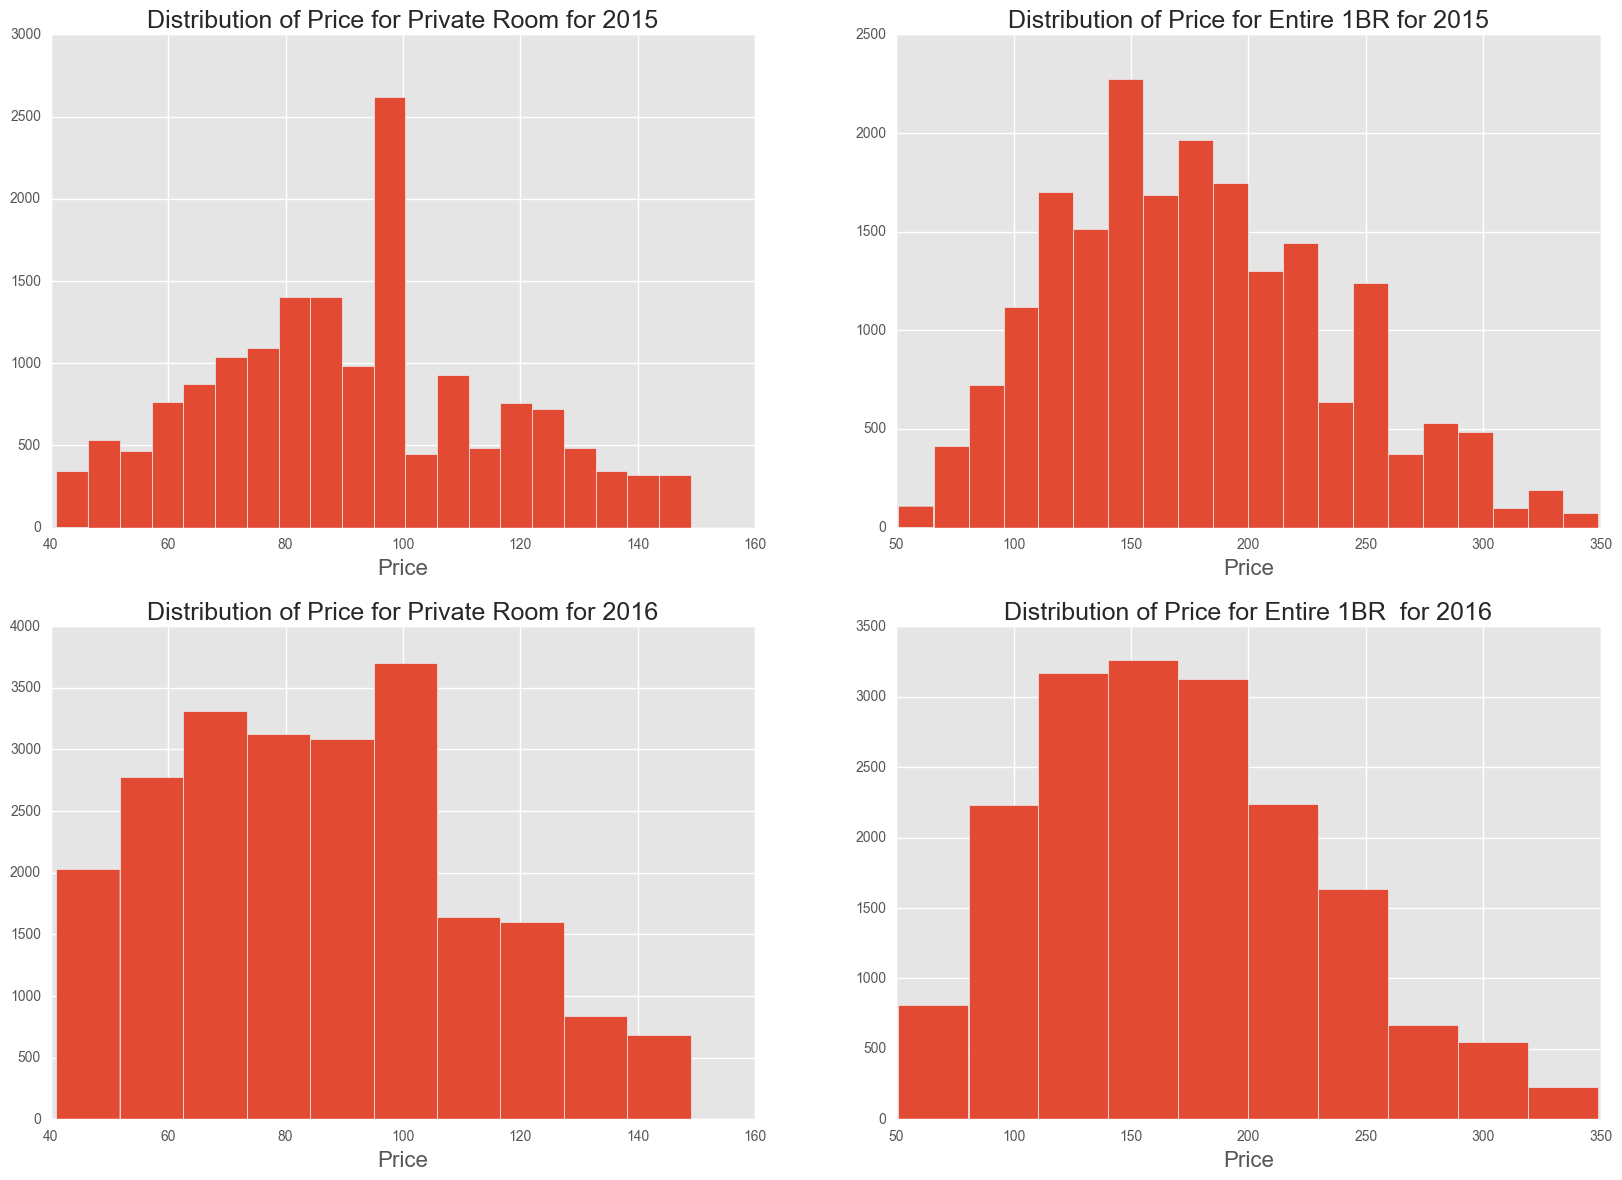

In [230]:
histogram_1br(data_1br15,data_1br16,2015,2016)

#### Visualizations for Entire unit Listings (studio, 1br, 2br, 3br, and 4br)

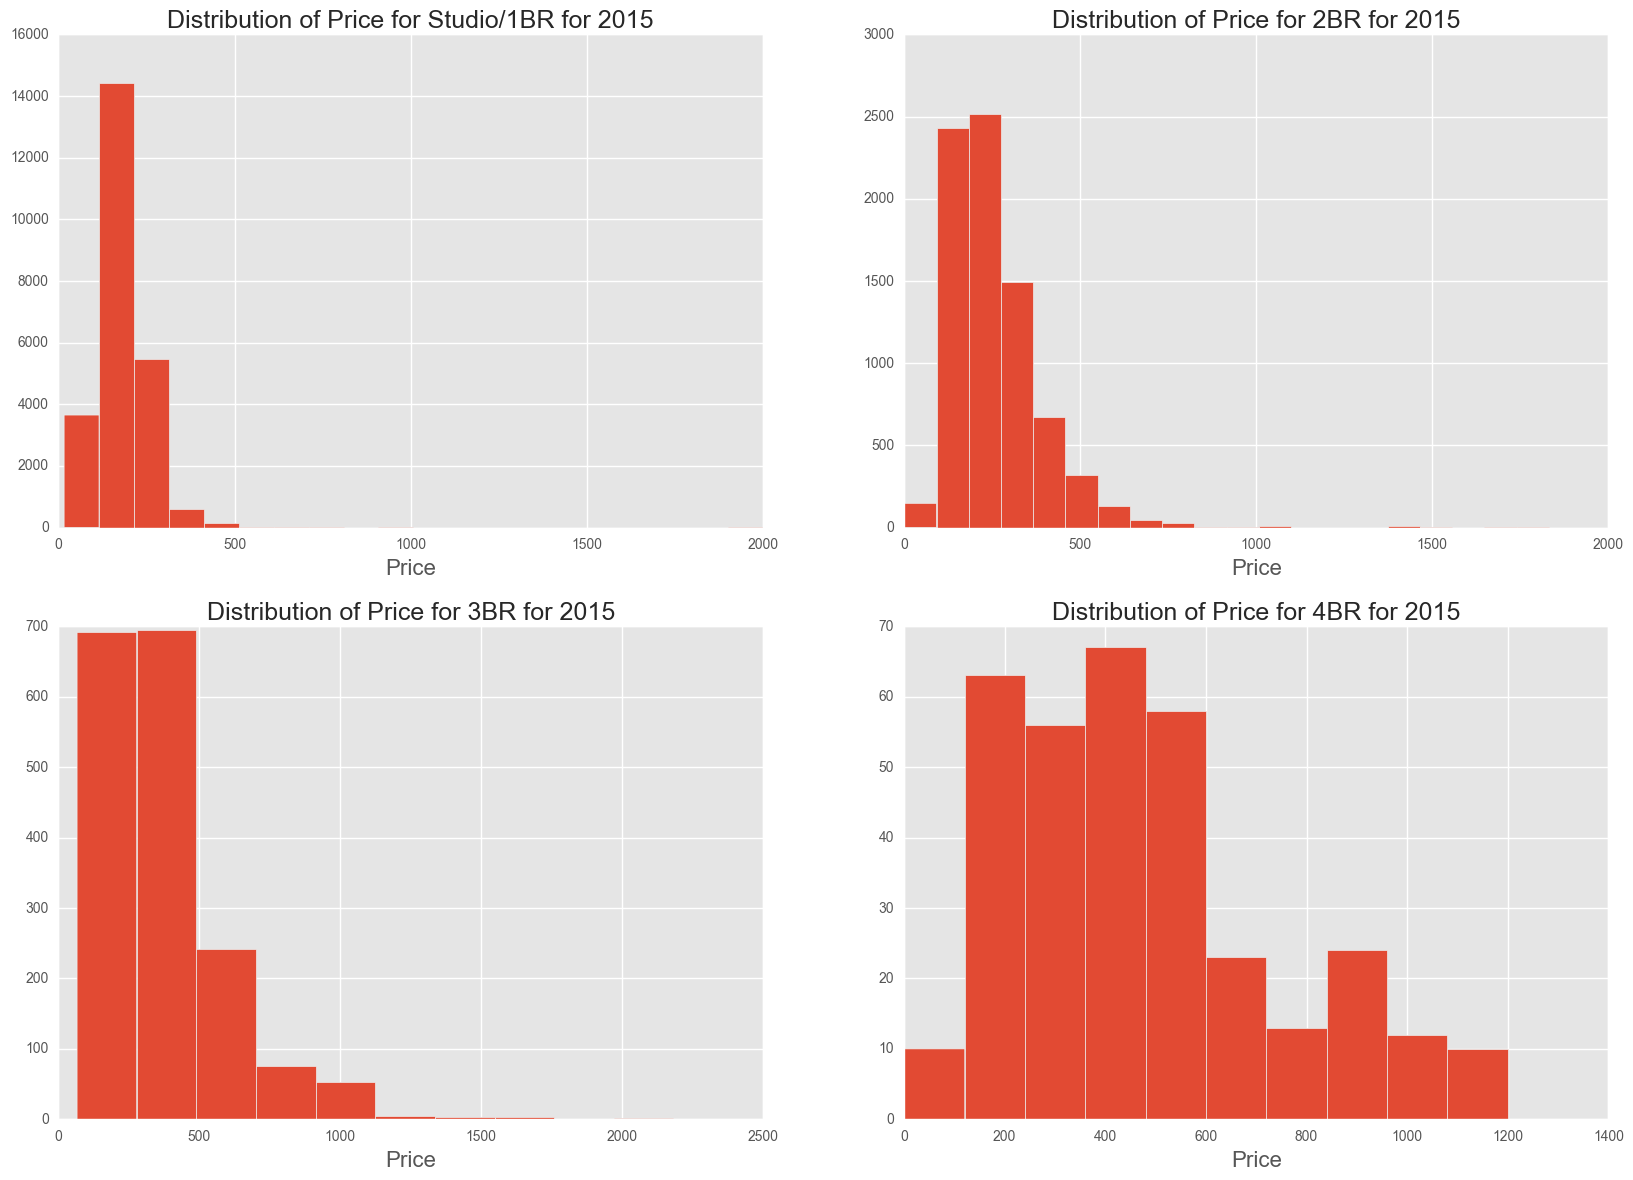

In [159]:
histograms(occ15_entire,2015)

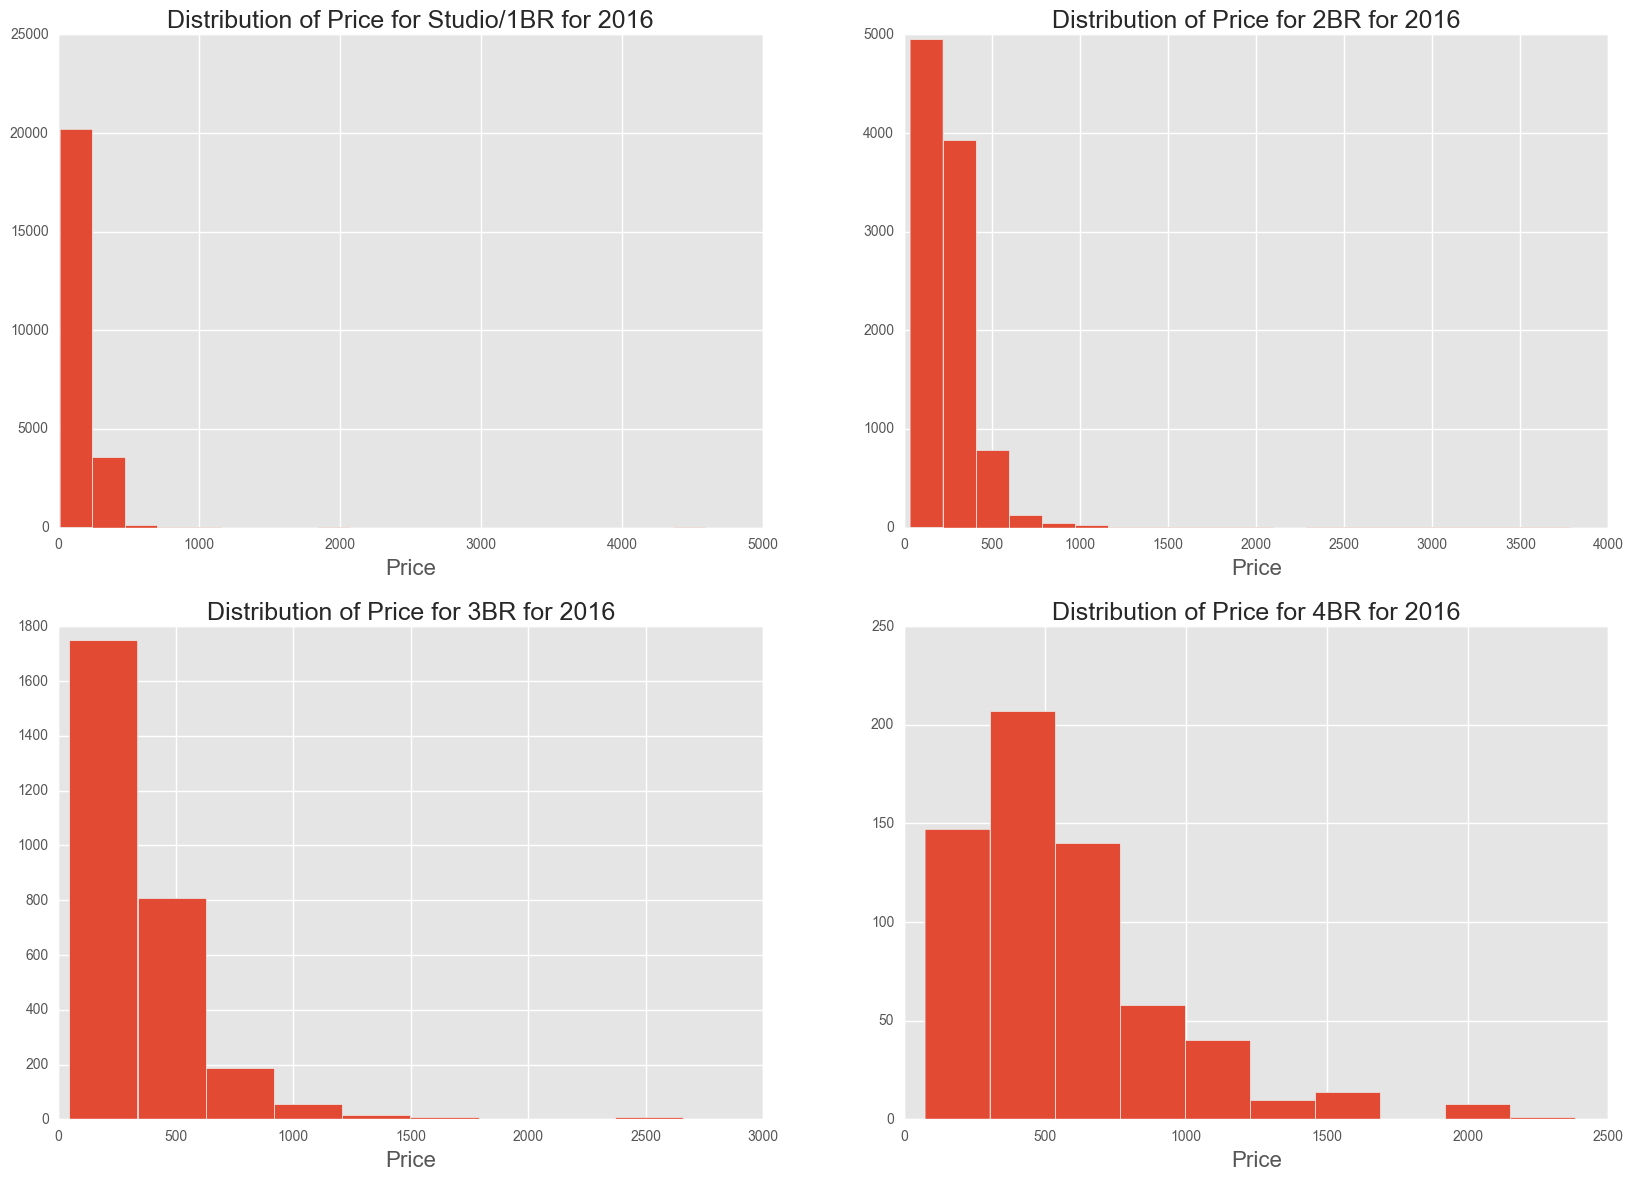

In [160]:
histograms(occ16_entire,2016)

The histograms show that each of the price distributions for the bedrooms is skewed to the right, thus the need to implement a cap on the lower and upper limit of the thresholds for price. Let's do that now. The function for price tresholds is under the function subcategory above.

In [185]:
data_2015 = price_thresholds(occ15_entire,50,350,85,600,85,800,100,1400)
data_2016 = price_thresholds(occ16_entire,50,350,85,600,85,800,100,1400)
data_2015.to_csv('data_2015'+date+'.csv')
data_2016.to_csv('data_2016'+date+'.csv')


Removing outliers, the dataframe shape is: (33207, 23)
Removing outliers, the dataframe shape is: (35375, 23)


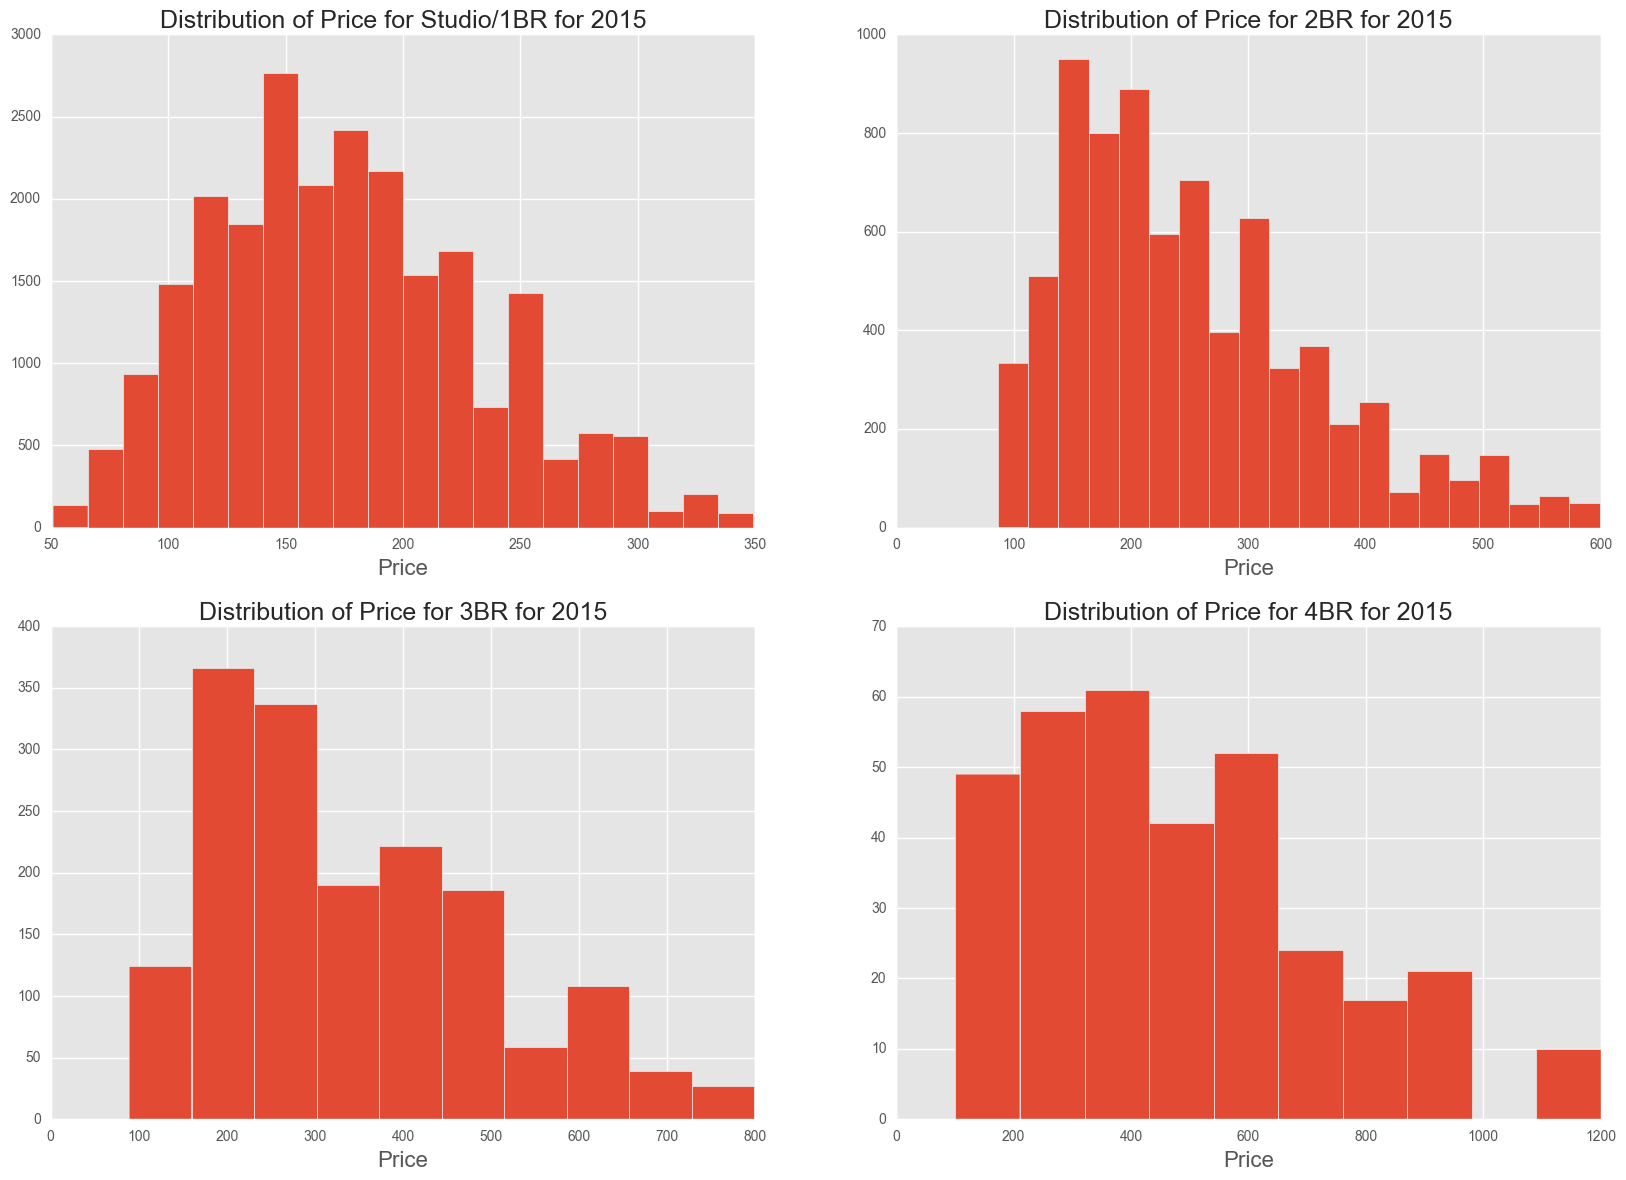

In [162]:
histograms(data_2015,2015)

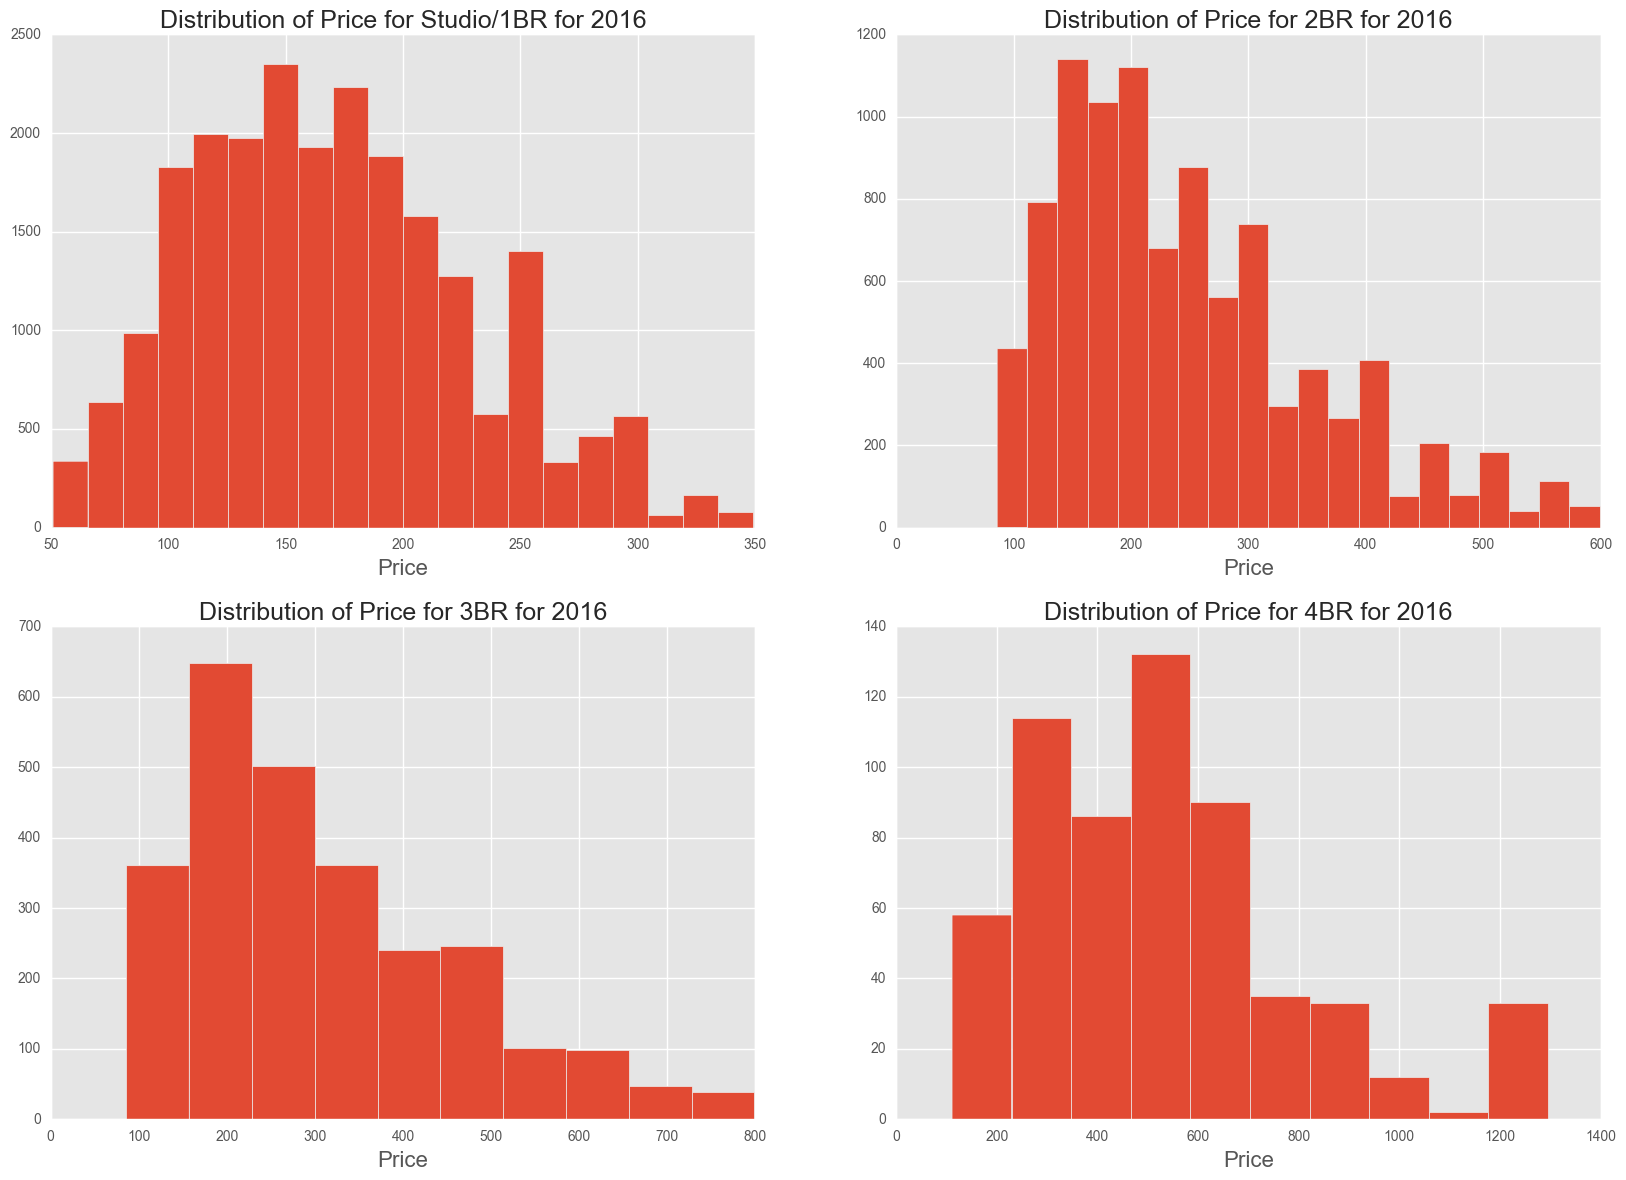

In [163]:
histograms(data_2016,2016)

As you can see, the distributions are more in line with a normal distribution as we removed the outliers for low and high prices. 

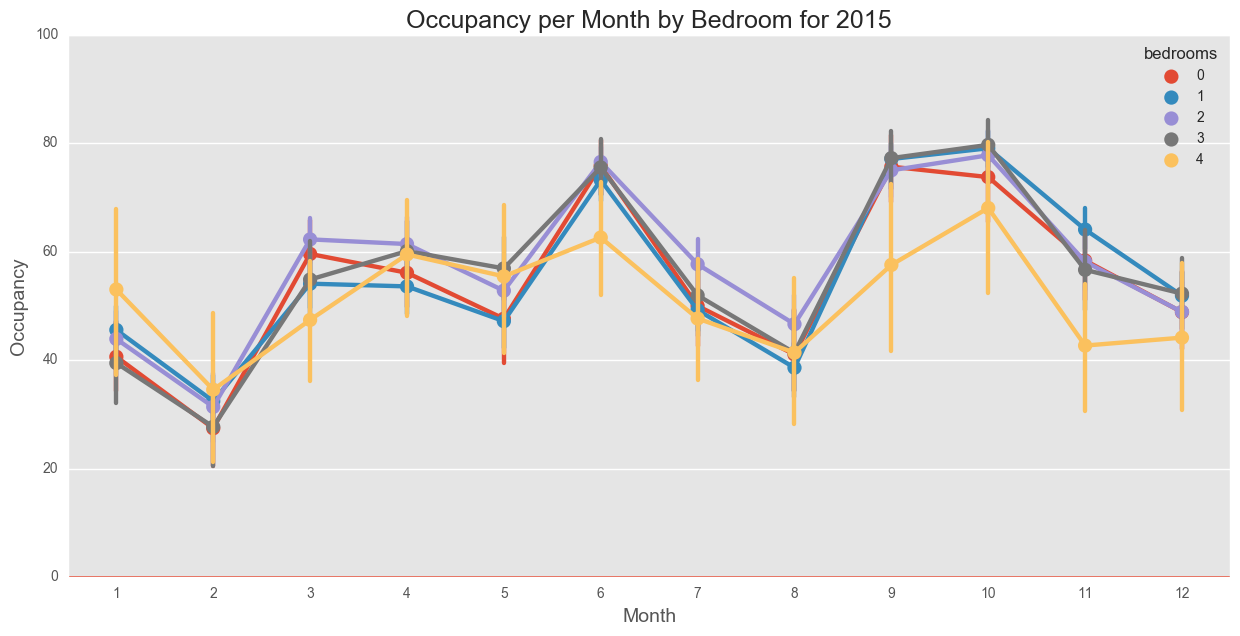

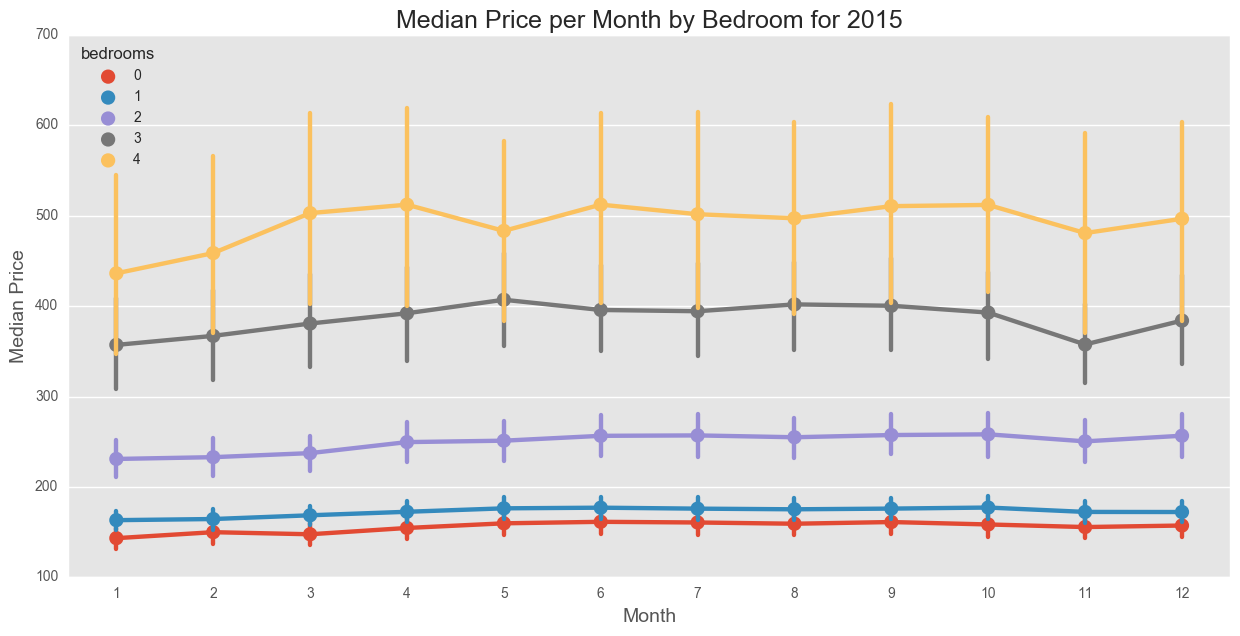

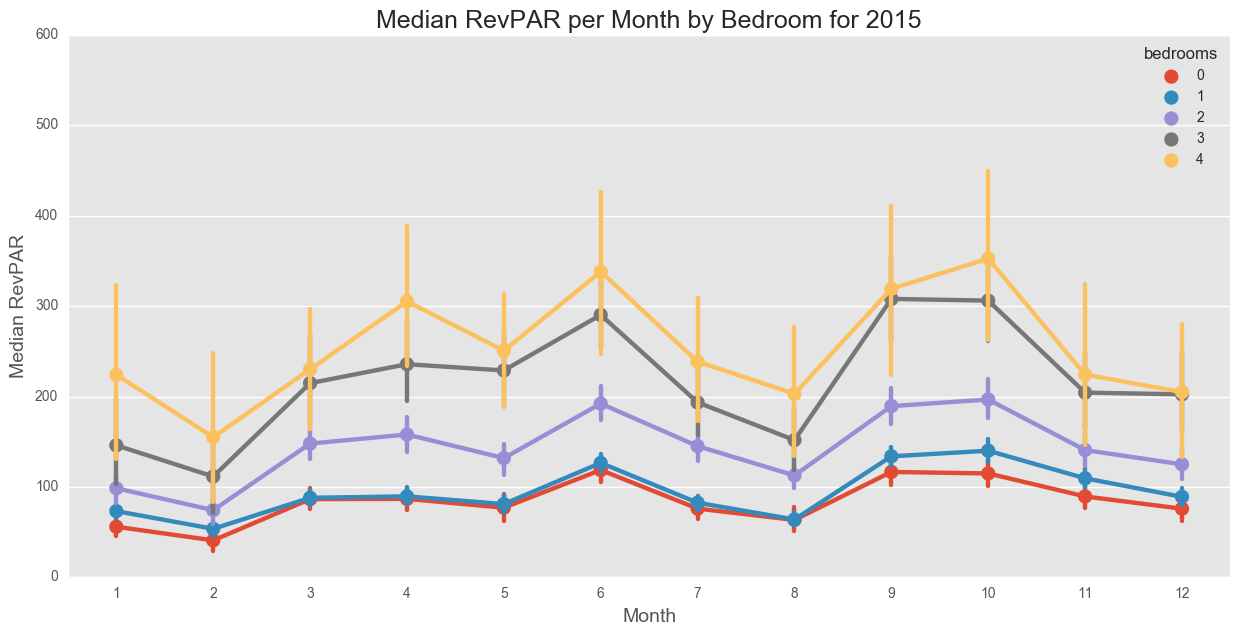

In [164]:
nhood_15 = trend_graphs(data_2015,2015)

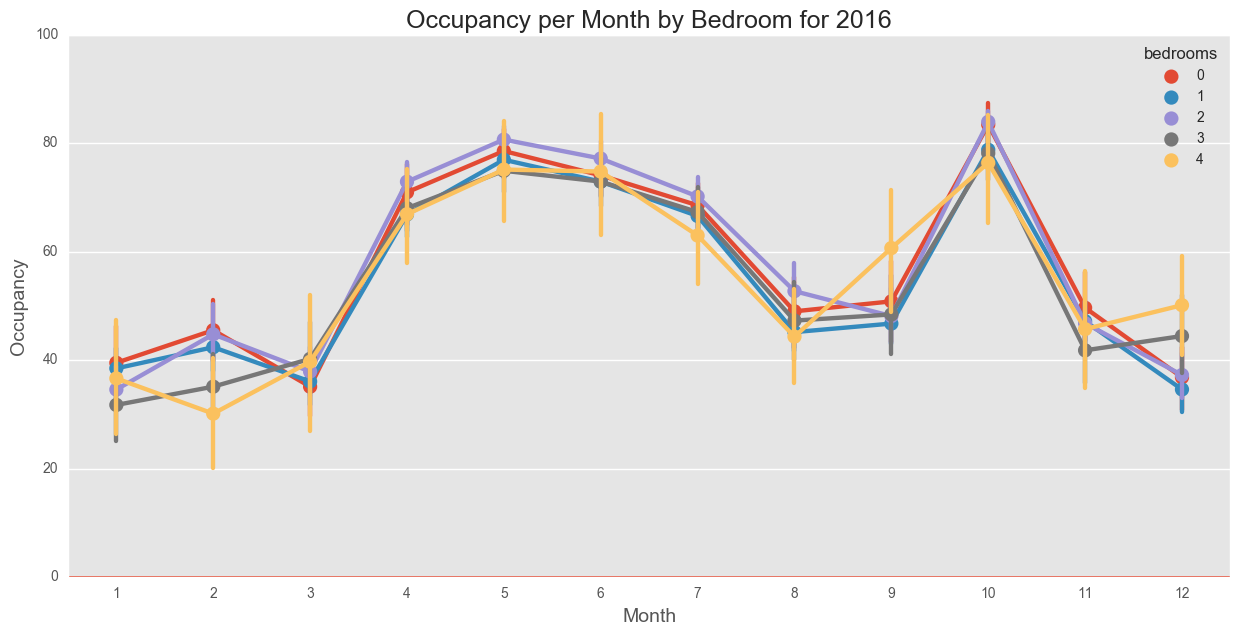

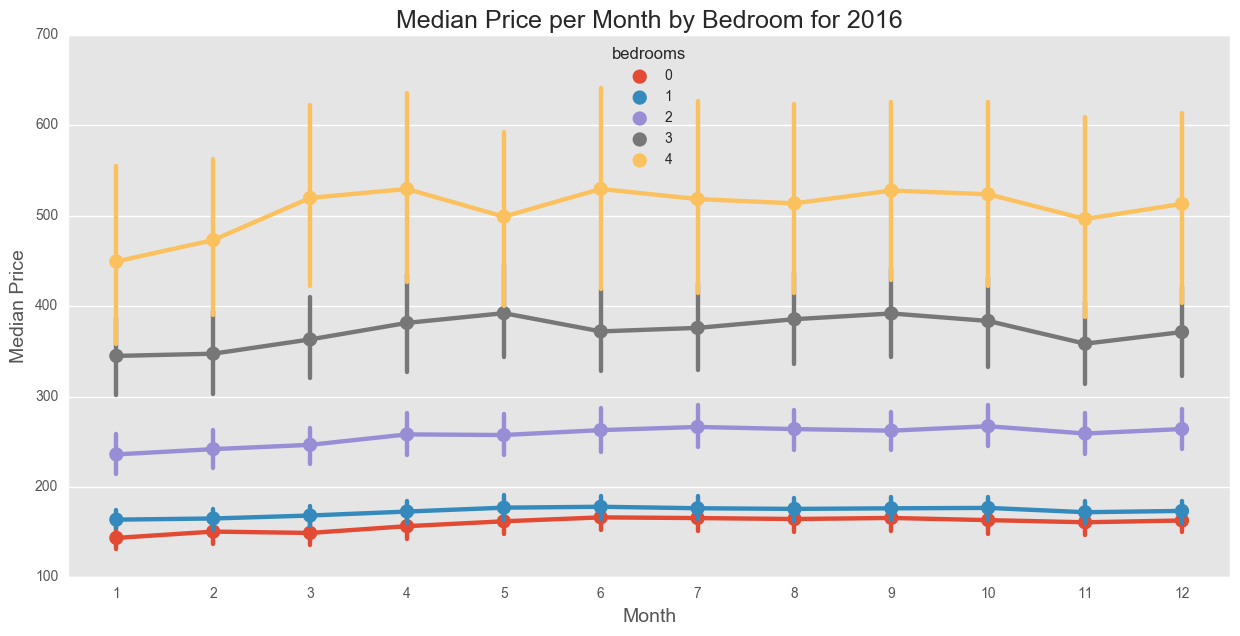

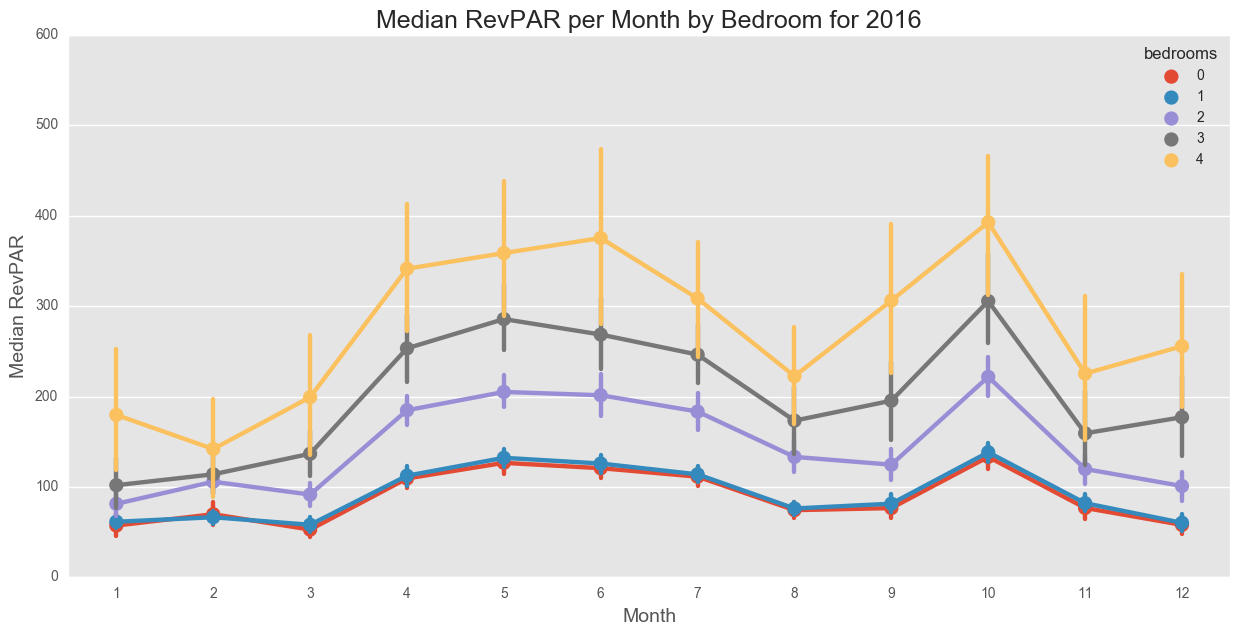

In [165]:
nhood_16 = trend_graphs(data_2016,2016)

### Model I - Predicting Prices for Private Room across Neighborhoods

PRICING ERROR IN THAT JANUARY MAY HAVE NYE PRICES AS AVG
#### Model Setup

In [445]:
private_15 = data_1br15[data_1br15['room_type']=='Private room']
private_16 = data_1br16[data_1br16['room_type']=='Private room']
print 'The Private Room datframe for 2015 is:',private_15.shape
print 'The Private Room datframe for 2016 is:',private_16.shape
print private_15.columns
cols = ['year','month','bedrooms','number_of_reviews','review_scores_rating','neighborhood','num_comps','occ%','avg_price']
priv_15df = private_15.loc[:,cols]
priv_16df = private_16.loc[:,cols]

#are there neighborhoods in 2015 that are not in 2016 or vice versa?
neighborhood_list = []
for x in priv_15df['neighborhood'].unique():
    neighborhood_list.append(x)
print len(neighborhood_list)
for x in priv_16df['neighborhood'].unique():
    if x not in neighborhood_list:
        neighborhood_list.append(x)
    else:
        pass
len(neighborhood_list)
#looks like there are neighborhoods in one df and not in another. lets combine the dataframes and fit a label encoder
priv_total = priv_15df.append(priv_16df)
priv_total.to_csv('combined_private_room_df.csv')
priv_total['review_scores_rating'] = priv_total['review_scores_rating'].astype(int)
priv_total['avg_price'] = priv_total['avg_price'].astype(int)

#call in the label encoder
le = LabelEncoder()

priv_total['neighborhood2'] = le.fit_transform(priv_total['neighborhood'])
#lets get a unique list of neighborhood and neighborhood2 (encoded) and save it to a df
neighborhood_keypair = priv_total.loc[:,['neighborhood','neighborhood2']].drop_duplicates()
neighborhood_keypair.reset_index(inplace = True,drop=True)
neighborhood_keypair.to_csv('neighborhood_keypairs.csv')

del priv_total['neighborhood']
priv_total.rename(columns = {'neighborhood2':'neighborhood'},inplace = True)
priv15 = priv_total[priv_total['year']==2015]
priv16 = priv_total[priv_total['year']==2016]
del priv15['year'],priv16['year'],priv15['bedrooms'],priv16['bedrooms']


y15 = priv15['avg_price']
y16 = priv16['avg_price']
del priv15['avg_price'],priv16['avg_price']
X15 = priv15
X16 = priv16
X15.corr()

The Private Room datframe for 2015 is: (16319, 22)
The Private Room datframe for 2016 is: (22793, 22)
Index([u'listing_id', u'year', u'month', u'days_per_month', u'available',
       u'occupied', u'occ_yr', u'occ%', u'occ_yr%', u'avg_price',
       u'neighborhood', u'zipcode', u'bedrooms', u'bathrooms', u'room_type',
       u'number_of_reviews', u'review_scores_rating', u'price', u'area',
       u'sub_area', u'num_comps', u'revpar'],
      dtype='object')
64


month  number_of_reviews  review_scores_rating  \
month                 1.000000           0.003249             -0.003893   
number_of_reviews     0.003249           1.000000              0.050432   
review_scores_rating -0.003893           0.050432              1.000000   
num_comps             0.001180          -0.048793             -0.065713   
occ%                  0.202340           0.027001              0.032528   
neighborhood         -0.004964           0.034225              0.046407   

                      num_comps      occ%  neighborhood  
month                  0.001180  0.202340     -0.004964  
number_of_reviews     -0.048793  0.027001      0.034225  
review_scores_rating  -0.065713  0.032528      0.046407  
num_comps              1.000000 -0.009084      0.441156  
occ%                  -0.009084  1.000000     -0.011672  
neighborhood           0.441156 -0.011672      1.000000

In [446]:
X16.corr()

month  number_of_reviews  review_scores_rating  \
month                 1.000000           0.005290             -0.007018   
number_of_reviews     0.005290           1.000000             -0.000845   
review_scores_rating -0.007018          -0.000845              1.000000   
num_comps             0.004215          -0.006072             -0.007117   
occ%                  0.024688           0.035202              0.035350   
neighborhood         -0.004803           0.004147              0.064404   

                      num_comps      occ%  neighborhood  
month                  0.004215  0.024688     -0.004803  
number_of_reviews     -0.006072  0.035202      0.004147  
review_scores_rating  -0.007117  0.035350      0.064404  
num_comps              1.000000  0.019236      0.241509  
occ%                   0.019236  1.000000      0.013421  
neighborhood           0.241509  0.013421      1.000000

#### Modeling

In [447]:
X_train,X_test,y_train,y_test = train_test_split(X15,y15,test_size = 0.33,random_state = 25)
X16_train,X16_test,y16_train,y16_test = train_test_split(X16,y16,test_size = 0.33,random_state = 25)

#### Linear Regression

In [448]:
lm = LinearRegression()
lm.fit = lm.fit(X_train,y_train)
lm_pred = lm.predict(X_test)
print mean_squared_error(y_test,lm_pred)
print r2_score(y_test,lm_pred)

558.180841693
0.0794890739158


#### Gradient Boosting

In [449]:
gb = GradientBoostingRegressor(n_estimators = 1000)
gb = gb.fit(X_train,y_train)
gb_pred = gb.predict(X_test)
print mean_squared_error(y_test,gb_pred)
print r2_score(y_test,gb_pred)

242.825034849
0.599550753073


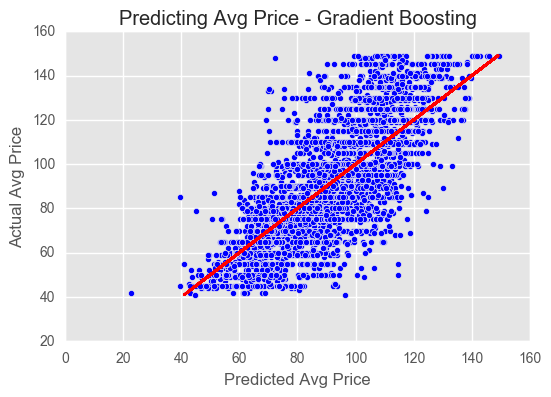

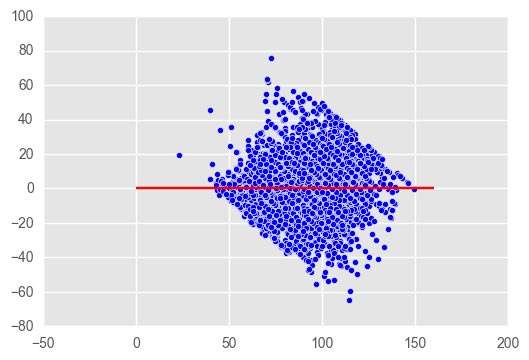

In [452]:
plt.scatter(gb_pred,y_test)
plt.plot(y_test,y_test,color='red')
plt.title('Predicting Avg Price - Gradient Boosting')
plt.xlabel('Predicted Avg Price')
plt.ylabel('Actual Avg Price')
plt.show()

plt.scatter(gb_pred,y_test - gb_pred)
plt.hlines(0,0,160,color='red')
plt.show();

In [451]:
gb_featur_imp = pd.concat([pd.Series(X15.columns,name="Features"),\
                           pd.Series(gb.feature_importances_,name="Feature Importance")],axis=1)
gb_featur_imp.sort_values('Feature Importance',ascending=False,inplace = True)
gb_featur_imp

Features  Feature Importance
1     number_of_reviews            0.314511
5          neighborhood            0.222729
2  review_scores_rating            0.189639
3             num_comps            0.142310
4                  occ%            0.088357
0                 month            0.042454

#### Analyzing MSE and R2 for different limits on avg price for 2015 private rooms

In [259]:
for x in [50,60,70,80,90,100,110,120,130,140,151]:
    priv15_gb = priv_total[(priv_total['avg_price']<=x) & (priv_total['year']==2015)]
    y_gb = priv15_gb['avg_price']
    del priv15_gb['avg_price']
    del priv15_gb['year'],priv15_gb['bedrooms']
    X_gb = priv15_gb
    Xgb_train,Xgb_test,ygb_train,ygb_test = train_test_split(X_gb,y_gb,test_size = 0.33,random_state = 25)
    gb1 = GradientBoostingRegressor(n_estimators=1000)
    gb1 = gb1.fit(Xgb_train,ygb_train)
    gb1_pred = gb1.predict(Xgb_test)
    print "For Average Price of "+str(x)
    print "MSE",mean_squared_error(ygb_test,gb1_pred)
    print "R2 score",r2_score(ygb_test,gb1_pred)
    print "--------------------------------------"

For Average Price of 50
MSE 4.03807211996
R2 score 0.359547439607
--------------------------------------
For Average Price of 60
MSE 17.3205268524
R2 score 0.412870716544
--------------------------------------
For Average Price of 70
MSE 29.3831978602
R2 score 0.550071082401
--------------------------------------
For Average Price of 80
MSE 53.353485636
R2 score 0.529538198155
--------------------------------------
For Average Price of 90
MSE 77.5880883765
R2 score 0.538453658679
--------------------------------------
For Average Price of 100
MSE 108.182258172
R2 score 0.568992483933
--------------------------------------
For Average Price of 110
MSE 133.552590087
R2 score 0.552728848027
--------------------------------------
For Average Price of 120
MSE 158.158955783
R2 score 0.585852442881
--------------------------------------
For Average Price of 130
MSE 185.324791637
R2 score 0.601617632143
--------------------------------------
For Average Price of 140
MSE 214.961705261
R2 score 

#### How are the results when the model is applied to 2016 data?

279.40272105
0.554339700559


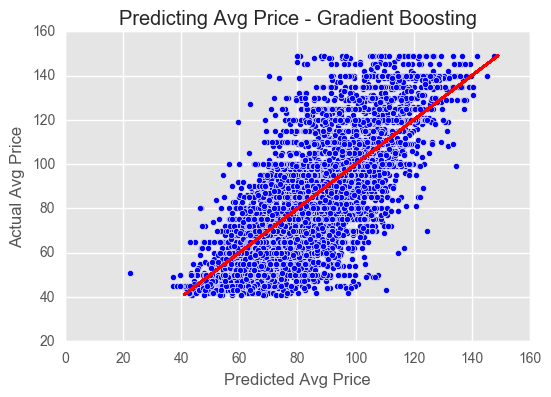

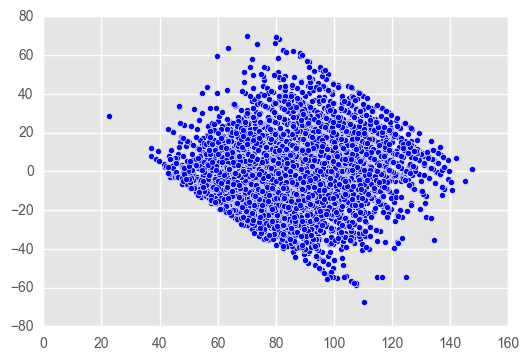

673.110415994
-0.0577211258441


In [453]:
gb2016 = GradientBoostingRegressor(n_estimators=1000)
gb2016 = gb2016.fit(X16_train,y16_train)
gb2016_pred = gb2016.predict(X16_test)
print mean_squared_error(y16_test,gb2016_pred)
print r2_score(y16_test,gb2016_pred)

plt.scatter(gb2016_pred,y16_test)
plt.plot(y16_test,y16_test,color='red')
plt.title('Predicting Avg Price - Gradient Boosting')
plt.xlabel('Predicted Avg Price')
plt.ylabel('Actual Avg Price')
plt.show()

plt.scatter(gb2016_pred,y16_test - gb2016_pred)
#plt.hlines()
plt.show();

gb2016_predict = gb.predict(X16)
print mean_squared_error(y16,gb2016_predict)
print r2_score(y16,gb2016_predict)


#using 2016 data on the predict function for the 2015 data, resulted in a -0.05 r2 which is not great

#### Results

There are patterns in the residuals indicating that there is underfitting. There seems to be one or more features that are missing from the model. It is harder to explain the price differences among private rooms as number of bedrooms isn't a feature, since there is only one bedroom. By evaluating the feature importances, number of reviews, neighborhood, and rating are the top 3 features. If a person is looking for a room, it is very likely that he/she are looking for a credible listing, one with highest reviews, rating in the neighborhood they are wanting. Since these people are most likely traveling alone, they looking to minimize the cost of a room, thus are shopping for a Private Room and not an Entire home/Apt. Occupancy% and Month are not factors, meaning they are not pressured by seasonal factors. 

Anonther model was done on 2016 data, given that the listings csv had more columns to choose from such as whether a host is a superhost, whether the unit is instant bookable, host response rate, and host response time. The model did not perform any better, so the conclusion is that there are other features that might explain the price differences, such as listing quality, and photo quality.

When applying prices to zillow

In [311]:
# list_2016 = pd.read_csv('/Users/amishdalal/Desktop/AirBnB-NYC/2016/listings.csv')
# #host_is_superhost,u'instant_bookable
# host_characteristics = list_2016.loc[:,['id','host_is_superhost','instant_bookable','host_response_time','host_response_rate']]
# host_characteristics['host_is_superhost'] = host_characteristics['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
# host_characteristics['instant_bookable'] = host_characteristics['instant_bookable'].apply(lambda x: 1 if x=='t' else 0)
# host_characteristics.rename(columns = {'id':'listing_id'},inplace = True)
# host_characteristics

In [310]:
# private_16
# cols2 = ['listing_id','month','bedrooms','number_of_reviews','review_scores_rating','neighborhood','num_comps','occ%','avg_price']
# priv16_test = private_16.loc[:,cols2]

# print priv16_test.shape
# priv16_test = pd.merge(priv16_test,neighborhood_keypair)
# del priv16_test['neighborhood'],priv16_test['bedrooms']
# priv16_test.rename(columns = {'neighborhood2':'neighborhood'},inplace = True)
# print priv16_test.shape
# priv16_test = pd.merge(priv16_test,host_characteristics)
# priv16_test = priv16_test[priv16_test['host_response_time'].notnull()]
# priv16_test['host_response_rate'] = priv16_test['host_response_rate'].apply(lambda x: x.replace('%','')).astype(int)
# y16t = priv16_test['avg_price']
# del priv16_test['avg_price']
# priv16_test['host_response_time'] = le.fit_transform(priv16_test['host_response_time'])

# del priv16_test['listing_id']
# X16t = priv16_test
# X16t_train,X16t_test,y16t_train,y16t_test = train_test_split(X16t,y16t,test_size = 0.33, random_state = 25)
# gb16t = GradientBoostingRegressor(n_estimators = 1000)
# gb16t = gb16t.fit(X16t_train,y16t_train)
# gb16t_pred = gb16t.predict(X16t_test)
# print "MSE",mean_squared_error(y16t_test,gb16t_pred)
# print "R2 score",r2_score(y16t_test,gb16t_pred)

### Model II - Predicting Prices for all bedrooms (entire home/apt) across Neighborhoods

In [572]:
total_data = data_2015.append(data_2016)
total_data['neighborhood'] = le.fit_transform(total_data['neighborhood'])
total_data = total_data.loc[:,cols]
data15 = total_data[total_data['year']==2015]
data16 = total_data[total_data['year']==2016]
del data15['year'],data16['year']
y15 = data15['avg_price']
y16 = data16['avg_price']
del data15['avg_price'], data16['avg_price']
X15 = data15
X16 = data16

In [573]:
X_train,X_test,y_train,y_test = train_test_split(X15,y15,test_size=0.33,random_state=25)

In [574]:
lm = LinearRegression()
lm.fit = lm.fit(X_train,y_train)
lm_pred = lm.predict(X_test)
print mean_squared_error(y_test,lm_pred)
print r2_score(y_test,lm_pred)

6766.33579947
0.284341473048


1027.71595704
0.891301036523


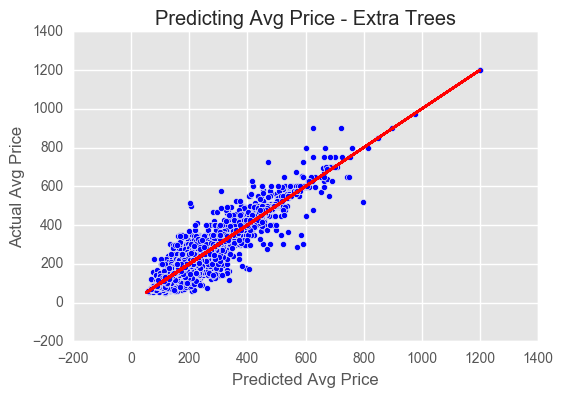

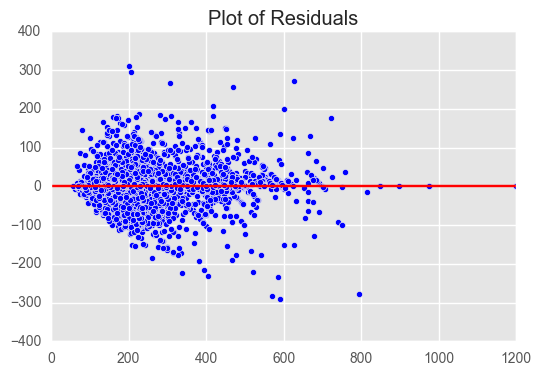

In [580]:
et = ExtraTreesRegressor(n_estimators = 100,n_jobs=-1)
et = et.fit(X_train,y_train)
et_pred = et.predict(X_test)
print mean_squared_error(y_test,et_pred)
print r2_score(y_test,et_pred)
plt.scatter(et_pred,y_test)
plt.plot(y_test,y_test,color='red')
plt.title('Predicting Avg Price - Extra Trees')
plt.xlabel('Predicted Avg Price')
plt.ylabel('Actual Avg Price')
plt.show()

plt.scatter(et_pred,y_test - et_pred)
#plt.hlines()
plt.xlim(0,1200)
plt.hlines(0,0,1200,color='red')
plt.title('Plot of Residuals')
plt.show();


In [576]:
et_feat_imp = pd.concat([pd.Series(X16.columns,name = 'Features'),pd.Series(et.feature_importances_,name='Feature Importances')],axis=1)
et_feat_imp.sort_values('Feature Importances',ascending=False)

Features  Feature Importances
1              bedrooms             0.290023
4          neighborhood             0.175972
2     number_of_reviews             0.148078
3  review_scores_rating             0.144157
5             num_comps             0.141252
6                  occ%             0.055668
0                 month             0.044851

In [577]:
gb = GradientBoostingRegressor(n_estimators = 1000)
gb = gb.fit(X_train,y_train)
gb_pred = gb.predict(X_test)
print mean_squared_error(y_test,gb_pred)
print r2_score(y_test,gb_pred)


2438.64583608
0.742070488587


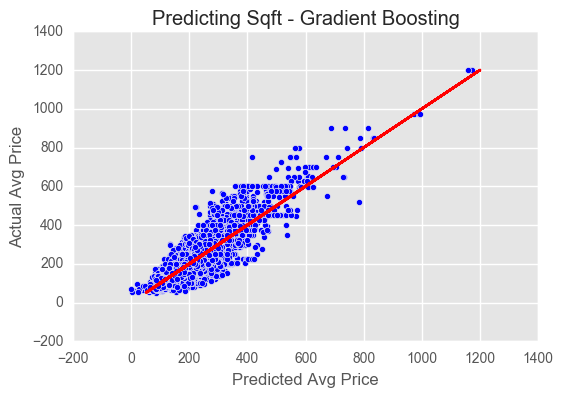

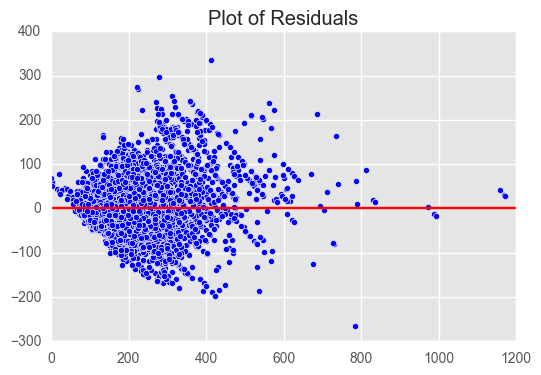

In [582]:
plt.scatter(gb_pred,y_test)
plt.plot(y_test,y_test,color='red')
plt.title('Predicting Sqft - Gradient Boosting')
plt.xlabel('Predicted Avg Price')
plt.ylabel('Actual Avg Price')
plt.show()

plt.scatter(gb_pred,y_test - gb_pred)
plt.xlim(0,1200)
plt.hlines(0,0,1200,color='red')
plt.title("Plot of Residuals")
plt.show();

### Applying Private Room Avg Prices by Neighborhood and Apply to Zillow 2BR Listings

In [626]:
zillowdf['neighborhood'] = zillowdf['neighborhood'].apply(lambda x: 'Soho' if x=='SoHo' else x)
zillow2br = zillowdf[zillowdf['bedrooms']==2]
zillow2br = zillow2br.loc[:,['address','beds','list_url','price','sqft','zipcode','price/sqft','neighborhood','sub_area','area']]
#zillowdf.rename(columns={'beds':'bedrooms'},inplace = True)

#zillow2br.rename(columns={'beds':'bedrooms'},inplace = True)
#based on the neighborhood, we can find the average price for the year, average yearly occupancy, revpar

#combining both years
total_df = data_2015.append(data_2016)
private_df = private_15.append(private_16)

#constructing the average price groupby
avg_price = total_df.groupby(['neighborhood','bedrooms'])['avg_price'].agg([max,min,np.median,np.mean])
avg_price_private = private_df.groupby(['neighborhood','bedrooms'])['avg_price'].agg([max,min,np.median,np.mean])

avg_price.reset_index(inplace = True)
avg_price_private.reset_index(inplace = True)

#constructing occupancy groupby
yearly_occ = total_df.groupby(['neighborhood','bedrooms'])['occupied','days_per_month'].sum()
yearly_occ_private = private_df.groupby(['neighborhood','bedrooms'])['occupied','days_per_month'].sum()

yearly_occ.reset_index(inplace = True)
yearly_occ_private.reset_index(inplace = True)

yearly_occ['occ_yr%'] = (100*(yearly_occ['occupied'] / yearly_occ['days_per_month'])).round(2)
yearly_occ_private['occ_yr%'] = (100*(yearly_occ_private['occupied'] / yearly_occ_private['days_per_month'])).round(2)


metrics_yr = pd.merge(avg_price,yearly_occ.loc[:,['neighborhood','bedrooms','occ_yr%']],on=['neighborhood','bedrooms'])
metrics_yr_private = pd.merge(avg_price_private,yearly_occ_private.loc[:,['neighborhood','bedrooms','occ_yr%']],on=['neighborhood','bedrooms'])

metrics_yr['revpar'] = (metrics_yr['median'] * metrics_yr['occ_yr%']/100).round(2)
metrics_yr_private['revpar'] = (metrics_yr_private['median'] * metrics_yr_private['occ_yr%']/100).round(2)

eval_df = pd.merge(zillow2br,metrics_yr_private,on='neighborhood')
eval_df['sub_area'] = eval_df['sub_area'].apply(lambda x: 'Midtown' if x is np.nan else x)
#multiplying revpar by 365 will give the expected yearly revenue (revpar = adr*occupancy), revpar = revenue per avail room
eval_df['yearly_revenue'] = eval_df['revpar']*365
#for a two bedroom, only have to look at the cost of 1 of the br. Can STR be better than long-term lease?
eval_df['yearly_cost'] = eval_df['price']*12/2
eval_df['Rev_Diff'] = eval_df['yearly_revenue'] - eval_df['yearly_cost']
eval_df.sort_values('Rev_Diff',ascending=False)
eval_df.to_csv('results_'+date+".csv")


total_eval = pd.merge(zillowdf,metrics_yr,on=['neighborhood','bedrooms'])
total_eval['sub_area'] = total_eval['sub_area'].apply(lambda x: 'Midtown' if x is np.nan else x)
total_eval['revpar'] = (total_eval.loc[:,['median','mean']].min(axis=1) * total_eval['occ_yr%']/100).round(2)
total_eval['yearly_revenue'] = total_eval['revpar']*365

total_eval['yearly_cost'] = total_eval['price']*12
total_eval['Rev_Diff'] = total_eval['yearly_revenue'] - total_eval['yearly_cost']
del total_eval['listing_num'],total_eval['link']
total_eval[total_eval['Rev_Diff']>0].sort_values('Rev_Diff',ascending=False)

eval_df[eval_df['Rev_Diff']>0]

address  beds  \
3             308 W 49th St # 4RE, New York, NY 10019    NaN   
4            308 W 49th St APT 3R, New York, NY 10019    NaN   
18          300 W 49th St APT 502, New York, NY 10019    NaN   
19            308 W 49th St # 3RF, New York, NY 10019    NaN   
59           641 Hudson St APT 2C, New York, NY 10014    NaN   
60             55 Leroy St APT 4F, New York, NY 10014    NaN   
61             121 Bank St APT 1J, New York, NY 10014    NaN   
62           210 W 10th St APT 2A, New York, NY 10014    NaN   
72           434 E 11th St APT 2F, New York, NY 10009    NaN   
78           336 E 13th St APT 3C, New York, NY 10003    NaN   
92           220 E 29th St APT 2F, New York, NY 10016    NaN   
97           226 E 29th St APT 2D, New York, NY 10016    NaN   
98           226 E 29th St APT 4A, New York, NY 10016    NaN   
99             329 3rd Ave APT 22, New York, NY 10010    NaN   
115          321 E 48th St APT 8J, New York, NY 10017    NaN   
116         300 E 46th St APT 10C, New York, NY 10017    NaN   
117         216 E 47th St APT 21A, New York, NY 10017    NaN   
119         301 E 47th St APT 15E, New York, NY 10017    NaN   
120          301 E 47th St APT 6P, New York, NY 10017    NaN   
125          326 E 58th St APT 1B, New York, NY 10022    NaN   
126            349 E 51st St # 2F, New York, NY 10022    NaN   
133          320 E 49th St APT 37, New York, NY 10017    NaN   
135          301 E 47th St # 11D*, New York, NY 10017    NaN   
138            301 E 53rd St # 1G, New York, NY 10022    NaN   
140         420 E 54th St APT 17F, New York, NY 10022    NaN   
142         400 E 54th St APT 23D, New York, NY 10022    NaN   
163         172 W 109th St APT 4W, New York, NY 10025    NaN   
164     471 Central Park W APT 2E, New York, NY 10025    NaN   
166     471 Central Park W APT 2E, New York, NY 10025    NaN   
175          348 E 66th St APT 2W, New York, NY 10065    NaN   
..                                                 ...   ...   
513        634 Classon Ave APT 2A, Brooklyn, NY 11238    NaN   
514     634 Classon Ave # 2BAHRIV, Brooklyn, NY 11238    NaN   
515            500 Saint Johns Pl, Brooklyn, NY 11238    NaN   
516     500 Saint Johns Pl APT 1A, Brooklyn, NY 11238    NaN   
517     500 Saint Johns Pl APT 2B, Brooklyn, NY 11238    NaN   
518     500 Saint Johns Pl APT 1B, Brooklyn, NY 11238    NaN   
520           1926 Pacific St # 1, Brooklyn, NY 11233    NaN   
521  Hancock StIncomplete address or missing price?...   NaN   
522  (Undisclosed Address)Incomplete address or mis...   NaN   
539          791 Sterling Pl # 4H, Brooklyn, NY 11216    NaN   
540          791 Sterling Pl # 5L, Brooklyn, NY 11216    NaN   
541          1926 Pacific St # 2A, Brooklyn, NY 11233    NaN   
542               1926 Pacific St, Brooklyn, NY 11233    NaN   
543        1926 Pacific St APT 3F, Brooklyn, NY 11233    NaN   
544          1926 Pacific St # 3V, Brooklyn, NY 11233    NaN   
545      1982 Atlantic Ave APT 2F, Brooklyn, NY 11233    NaN   
546      1982 Atlantic Ave # 1234, Brooklyn, NY 11233    NaN   
552         1356 Dekalb Ave APT 7, Brooklyn, NY 11221    NaN   
553  Hancock Street #Incomplete address or missing ...   NaN   
571    487 Monroe Street # FL 2ND, Brooklyn, NY 11221    NaN   
583     1699 Lexington Ave APT 2C, New York, NY 10029    NaN   
584         322 E 104th St APT 2E, New York, NY 10029    NaN   
586         170 E 105th St APT 1C, New York, NY 10029    NaN   
590            1910 3rd Ave # 6FS, New York, NY 10029    NaN   
591         320 E 109th St APT 14, New York, NY 10029    NaN   
593         1261 Park Ave APT 12B, New York, NY 10029    NaN   
594          63 E 125th St APT 2D, New York, NY 10035    NaN   
597         206 W 148th St APT 6G, New York, NY 10039    NaN   
598           2504 Ac Powell Blvd, New York, NY 10039    NaN   
599         211 W 146th St APT 1C, New York, NY 10039    NaN   

                                              list_url  price  sqft  zipcode  

In [634]:
coordinates = []
for x in eval_df[eval_df['Rev_Diff']>0]['list_url']:
    coordinates.append(x)
    
for x in total_eval[total_eval['Rev_Diff']>0]['list_url']:
    if x not in coordinates:
        coordinates.append(x)
with open('zillow_files/get_coordinates.json', 'w') as fp:
    json.dump(coordinates, fp)
    

In [635]:
coordinates[1]

u'http://www.zillow.com/homedetails/308-W-49th-St-APT-3R-New-York-NY-10019/2097233047_zpid/'

## Findings/Results

## Conclusions

## Extra Visualizations!